# Model1

In [1]:
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
import os
import copy
import seaborn as sns
 
from sklearn import preprocessing
from sklearn.metrics import log_loss
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import QuantileTransformer
from sklearn.decomposition import PCA
 
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
 
import warnings
warnings.filterwarnings('ignore')

In [2]:
data_dir = '../input/lish-moa/'
os.listdir(data_dir)

['test_features.csv',
 'train_drug.csv',
 'train_features.csv',
 'train_targets_scored.csv',
 'train_targets_nonscored.csv',
 'sample_submission.csv']

In [3]:
#!pip install /kaggle/input/iterative-stratification/iterative-stratification-master/
import sys
sys.path.append('../input/iterative-stratification/iterative-stratification-master/')
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold

In [4]:
train_features = pd.read_csv(data_dir + 'train_features.csv')
train_targets_scored = pd.read_csv(data_dir + 'train_targets_scored.csv')
train_targets_nonscored = pd.read_csv(data_dir + 'train_targets_nonscored.csv')
train_drug = pd.read_csv(data_dir + 'train_drug.csv')
test_features = pd.read_csv(data_dir + 'test_features.csv')
sample_submission = pd.read_csv(data_dir + 'sample_submission.csv')

print('train_features: {}'.format(train_features.shape))
print('train_targets_scored: {}'.format(train_targets_scored.shape))
print('train_targets_nonscored: {}'.format(train_targets_nonscored.shape))
print('train_drug: {}'.format(train_drug.shape))
print('test_features: {}'.format(test_features.shape))
print('sample_submission: {}'.format(sample_submission.shape))

train_features: (23814, 876)
train_targets_scored: (23814, 207)
train_targets_nonscored: (23814, 403)
train_drug: (23814, 2)
test_features: (3982, 876)
sample_submission: (3982, 207)


In [5]:
train_features2=train_features.copy()
test_features2=test_features.copy()

In [6]:
GENES = [col for col in train_features.columns if col.startswith('g-')]
CELLS = [col for col in train_features.columns if col.startswith('c-')]

In [7]:
qt = QuantileTransformer(n_quantiles=100,random_state=42,output_distribution='normal')
data = pd.concat([pd.DataFrame(train_features[GENES+CELLS]), pd.DataFrame(test_features[GENES+CELLS])])
data2 = qt.fit_transform(data[GENES+CELLS])
train_features[GENES+CELLS] = pd.DataFrame(data2[:train_features.shape[0]])
test_features[GENES+CELLS] = pd.DataFrame(data2[-test_features.shape[0]:])

In [8]:
def seed_everything(seed_value):
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)

    if torch.cuda.is_available(): 
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
    
seed_everything(42)

In [9]:
n_comp = 600  #<--Update

data = pd.concat([pd.DataFrame(train_features[GENES]), pd.DataFrame(test_features[GENES])])
data2 = (PCA(n_components=n_comp, random_state=42).fit_transform(data[GENES]))
train2 = data2[:train_features.shape[0]]; 
test2 = data2[-test_features.shape[0]:]

train_gpca = pd.DataFrame(train2, columns=[f'pca_G-{i}' for i in range(n_comp)])
test_gpca = pd.DataFrame(test2, columns=[f'pca_G-{i}' for i in range(n_comp)])

# drop_cols = [f'c-{i}' for i in range(n_comp,len(GENES))]
train_features = pd.concat((train_features, train_gpca), axis=1)
test_features = pd.concat((test_features, test_gpca), axis=1)

In [10]:
n_comp = 50  #<--Update

data = pd.concat([pd.DataFrame(train_features[CELLS]), pd.DataFrame(test_features[CELLS])])
data2 = (PCA(n_components=n_comp, random_state=42).fit_transform(data[CELLS]))
train2 = data2[:train_features.shape[0]]; test2 = data2[-test_features.shape[0]:]

train_cpca = pd.DataFrame(train2, columns=[f'pca_C-{i}' for i in range(n_comp)])
test_cpca = pd.DataFrame(test2, columns=[f'pca_C-{i}' for i in range(n_comp)])

# drop_cols = [f'c-{i}' for i in range(n_comp,len(CELLS))]
train_features = pd.concat((train_features, train_cpca), axis=1)
test_features = pd.concat((test_features, test_cpca), axis=1)

In [11]:
from sklearn.feature_selection import VarianceThreshold


var_thresh = VarianceThreshold(0.85)  #<-- Update
data = train_features.append(test_features)
data_transformed = var_thresh.fit_transform(data.iloc[:, 4:])

train_features_transformed = data_transformed[ : train_features.shape[0]]
test_features_transformed = data_transformed[-test_features.shape[0] : ]


train_features = pd.DataFrame(train_features[['sig_id','cp_type','cp_time','cp_dose']].values.reshape(-1, 4),\
                              columns=['sig_id','cp_type','cp_time','cp_dose'])

train_features = pd.concat([train_features, pd.DataFrame(train_features_transformed)], axis=1)


test_features = pd.DataFrame(test_features[['sig_id','cp_type','cp_time','cp_dose']].values.reshape(-1, 4),\
                             columns=['sig_id','cp_type','cp_time','cp_dose'])

test_features = pd.concat([test_features, pd.DataFrame(test_features_transformed)], axis=1)


In [12]:
from sklearn.cluster import KMeans
def fe_cluster(train, test, n_clusters_g = 22, n_clusters_c = 4, SEED = 42):
    
    features_g = GENES
    features_c = CELLS
    
    def create_cluster(train, test, features, kind = 'g', n_clusters = n_clusters_g):
        train_ = train[features].copy()
        test_ = test[features].copy()
        data = pd.concat([train_, test_], axis = 0)
        kmeans = KMeans(n_clusters = n_clusters, random_state = SEED).fit(data)
        train[f'clusters_{kind}'] = kmeans.labels_[:train.shape[0]]
        test[f'clusters_{kind}'] = kmeans.labels_[train.shape[0]:]
        train = pd.get_dummies(train, columns = [f'clusters_{kind}'])
        test = pd.get_dummies(test, columns = [f'clusters_{kind}'])
        return train, test
    
    train, test = create_cluster(train, test, features_g, kind = 'g', n_clusters = n_clusters_g)
    train, test = create_cluster(train, test, features_c, kind = 'c', n_clusters = n_clusters_c)
    return train, test

train_features2 ,test_features2=fe_cluster(train_features2,test_features2)

In [13]:
train_pca=pd.concat((train_gpca,train_cpca),axis=1)
test_pca=pd.concat((test_gpca,test_cpca),axis=1)

In [14]:
def fe_cluster_pca(train, test,n_clusters=5,SEED = 42):
        data=pd.concat([train,test],axis=0)
        kmeans = KMeans(n_clusters = n_clusters, random_state = SEED).fit(data)
        train[f'clusters_pca'] = kmeans.labels_[:train.shape[0]]
        test[f'clusters_pca'] = kmeans.labels_[train.shape[0]:]
        train = pd.get_dummies(train, columns = [f'clusters_pca'])
        test = pd.get_dummies(test, columns = [f'clusters_pca'])
        return train, test
train_cluster_pca ,test_cluster_pca = fe_cluster_pca(train_pca,test_pca)

In [15]:
train_cluster_pca = train_cluster_pca.iloc[:,650:]
test_cluster_pca = test_cluster_pca.iloc[:,650:]

In [16]:
train_features_cluster=train_features2.iloc[:,876:]
test_features_cluster=test_features2.iloc[:,876:]

In [17]:
gsquarecols=['g-574','g-211','g-216','g-0','g-255','g-577','g-153','g-389','g-60','g-370','g-248','g-167','g-203','g-177','g-301','g-332','g-517','g-6','g-744','g-224','g-162','g-3','g-736','g-486','g-283','g-22','g-359','g-361','g-440','g-335','g-106','g-307','g-745','g-146','g-416','g-298','g-666','g-91','g-17','g-549','g-145','g-157','g-768','g-568','g-396']

In [18]:
def fe_stats(train, test):
    
    features_g = GENES
    features_c = CELLS
    
    for df in train, test:
        df['g_sum'] = df[features_g].sum(axis = 1)
        df['g_mean'] = df[features_g].mean(axis = 1)
        df['g_std'] = df[features_g].std(axis = 1)
        df['g_kurt'] = df[features_g].kurtosis(axis = 1)
        df['g_skew'] = df[features_g].skew(axis = 1)
        df['c_sum'] = df[features_c].sum(axis = 1)
        df['c_mean'] = df[features_c].mean(axis = 1)
        df['c_std'] = df[features_c].std(axis = 1)
        df['c_kurt'] = df[features_c].kurtosis(axis = 1)
        df['c_skew'] = df[features_c].skew(axis = 1)
        df['gc_sum'] = df[features_g + features_c].sum(axis = 1)
        df['gc_mean'] = df[features_g + features_c].mean(axis = 1)
        df['gc_std'] = df[features_g + features_c].std(axis = 1)
        df['gc_kurt'] = df[features_g + features_c].kurtosis(axis = 1)
        df['gc_skew'] = df[features_g + features_c].skew(axis = 1)
        
        df['c52_c42'] = df['c-52'] * df['c-42']
        df['c13_c73'] = df['c-13'] * df['c-73']
        df['c26_c13'] = df['c-23'] * df['c-13']
        df['c33_c6'] = df['c-33'] * df['c-6']
        df['c11_c55'] = df['c-11'] * df['c-55']
        df['c38_c63'] = df['c-38'] * df['c-63']
        df['c38_c94'] = df['c-38'] * df['c-94']
        df['c13_c94'] = df['c-13'] * df['c-94']
        df['c4_c52'] = df['c-4'] * df['c-52']
        df['c4_c42'] = df['c-4'] * df['c-42']
        df['c13_c38'] = df['c-13'] * df['c-38']
        df['c55_c2'] = df['c-55'] * df['c-2']
        df['c55_c4'] = df['c-55'] * df['c-4']
        df['c4_c13'] = df['c-4'] * df['c-13']
        df['c82_c42'] = df['c-82'] * df['c-42']
        df['c66_c42'] = df['c-66'] * df['c-42']
        df['c6_c38'] = df['c-6'] * df['c-38']
        df['c2_c13'] = df['c-2'] * df['c-13']
        df['c62_c42'] = df['c-62'] * df['c-42']
        df['c90_c55'] = df['c-90'] * df['c-55']
        
        
        for feature in features_c:
             df[f'{feature}_squared'] = df[feature] ** 2     
                
        for feature in gsquarecols:
            df[f'{feature}_squared'] = df[feature] ** 2        
        
    return train, test

train_features2,test_features2=fe_stats(train_features2,test_features2)

In [19]:
train_features_stats=train_features2.iloc[:,902:]
test_features_stats=test_features2.iloc[:,902:]


In [20]:
train_features = pd.concat((train_features, train_features_cluster,train_cluster_pca,train_features_stats), axis=1)
test_features = pd.concat((test_features, test_features_cluster,test_cluster_pca,test_features_stats), axis=1)

In [21]:
#train_drug.head()

In [22]:
train = train_features.merge(train_targets_scored, on='sig_id')
train = train.merge(train_targets_nonscored, on='sig_id')
train = train.merge(train_drug, on='sig_id')
train = train[train['cp_type'] != 'ctl_vehicle'].reset_index(drop=True)
test = test_features[test_features['cp_type'] != 'ctl_vehicle'].reset_index(drop=True)

In [23]:
train = train.drop('cp_type', axis=1)
test = test.drop('cp_type', axis=1)

In [24]:
#train.head()

In [25]:
target_cols = [x for x in train_targets_scored.columns if x != 'sig_id']
aux_target_cols = [x for x in train_targets_nonscored.columns if x != 'sig_id']
all_target_cols = target_cols + aux_target_cols

num_targets = len(target_cols)
num_aux_targets = len(aux_target_cols)
num_all_targets = len(all_target_cols)

#print('num_targets: {}'.format(num_targets))
#print('num_aux_targets: {}'.format(num_aux_targets))
#print('num_all_targets: {}'.format(num_all_targets))

print(train.shape)
print(test.shape)
print(sample_submission.shape)

# Dataset Classes

In [26]:
class MoADataset:
    def __init__(self, features, targets):
        self.features = features
        self.targets = targets
        
    def __len__(self):
        return (self.features.shape[0])
    
    def __getitem__(self, idx):
        dct = {
            'x' : torch.tensor(self.features[idx, :], dtype=torch.float),
            'y' : torch.tensor(self.targets[idx, :], dtype=torch.float)
        }
        
        return dct
    
class TestDataset:
    def __init__(self, features):
        self.features = features
        
    def __len__(self):
        return (self.features.shape[0])
    
    def __getitem__(self, idx):
        dct = {
            'x' : torch.tensor(self.features[idx, :], dtype=torch.float)
        }

        return dct

In [27]:
def train_fn(model, optimizer, scheduler, loss_fn, dataloader, device):
    model.train()
    final_loss = 0
    
    for data in dataloader:
        optimizer.zero_grad()
        inputs, targets = data['x'].to(device), data['y'].to(device)
        outputs = model(inputs)
        loss = loss_fn(outputs, targets)
        loss.backward()
        optimizer.step()
        scheduler.step()

        final_loss += loss.item()
        
    final_loss /= len(dataloader)
    return final_loss

def valid_fn(model, loss_fn, dataloader, device):
    model.eval()
    final_loss = 0
    valid_preds = []
    
    for data in dataloader:
        inputs, targets = data['x'].to(device), data['y'].to(device)
        outputs = model(inputs)
        loss = loss_fn(outputs, targets)

        final_loss += loss.item()
        valid_preds.append(outputs.sigmoid().detach().cpu().numpy())
        
    final_loss /= len(dataloader)
    valid_preds = np.concatenate(valid_preds)
    return final_loss, valid_preds

def inference_fn(model, dataloader, device):
    model.eval()
    preds = []
    
    for data in dataloader:
        inputs = data['x'].to(device)

        with torch.no_grad():
            outputs = model(inputs)
        
        preds.append(outputs.sigmoid().detach().cpu().numpy())
        
    preds = np.concatenate(preds)
    return preds

In [28]:
import torch
from torch.nn.modules.loss import _WeightedLoss
import torch.nn.functional as F

class SmoothBCEwLogits(_WeightedLoss):
    def __init__(self, weight=None, reduction='mean', smoothing=0.0):
        super().__init__(weight=weight, reduction=reduction)
        self.smoothing = smoothing
        self.weight = weight
        self.reduction = reduction

    @staticmethod
    def _smooth(targets:torch.Tensor, n_labels:int, smoothing=0.0):
        assert 0 <= smoothing < 1

        with torch.no_grad():
            targets = targets * (1.0 - smoothing) + 0.5 * smoothing
            
        return targets

    def forward(self, inputs, targets):
        targets = SmoothBCEwLogits._smooth(targets, inputs.size(-1),
            self.smoothing)
        loss = F.binary_cross_entropy_with_logits(inputs, targets,self.weight)

        if  self.reduction == 'sum':
            loss = loss.sum()
        elif  self.reduction == 'mean':
            loss = loss.mean()

        return loss

# Model

In [29]:
class Model(nn.Module):
    def __init__(self, num_features, num_targets):
        super(Model, self).__init__()
        self.hidden_size = [1500, 1250, 1000, 750]
        self.dropout_value = [0.5, 0.35, 0.3, 0.25]

        self.batch_norm1 = nn.BatchNorm1d(num_features)
        self.dense1 = nn.Linear(num_features, self.hidden_size[0])
        
        self.batch_norm2 = nn.BatchNorm1d(self.hidden_size[0])
        self.dropout2 = nn.Dropout(self.dropout_value[0])
        self.dense2 = nn.Linear(self.hidden_size[0], self.hidden_size[1])

        self.batch_norm3 = nn.BatchNorm1d(self.hidden_size[1])
        self.dropout3 = nn.Dropout(self.dropout_value[1])
        self.dense3 = nn.Linear(self.hidden_size[1], self.hidden_size[2])

        self.batch_norm4 = nn.BatchNorm1d(self.hidden_size[2])
        self.dropout4 = nn.Dropout(self.dropout_value[2])
        self.dense4 = nn.Linear(self.hidden_size[2], self.hidden_size[3])

        self.batch_norm5 = nn.BatchNorm1d(self.hidden_size[3])
        self.dropout5 = nn.Dropout(self.dropout_value[3])
        self.dense5 = nn.utils.weight_norm(nn.Linear(self.hidden_size[3], num_targets))
    
    def forward(self, x):
        x = self.batch_norm1(x)
        x = F.leaky_relu(self.dense1(x))
        
        x = self.batch_norm2(x)
        x = self.dropout2(x)
        x = F.leaky_relu(self.dense2(x))

        x = self.batch_norm3(x)
        x = self.dropout3(x)
        x = F.leaky_relu(self.dense3(x))

        x = self.batch_norm4(x)
        x = self.dropout4(x)
        x = F.leaky_relu(self.dense4(x))

        x = self.batch_norm5(x)
        x = self.dropout5(x)
        x = self.dense5(x)
        return x
    
class LabelSmoothingLoss(nn.Module):
    def __init__(self, classes, smoothing=0.0, dim=-1):
        super(LabelSmoothingLoss, self).__init__()
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing
        self.cls = classes
        self.dim = dim

    def forward(self, pred, target):
        pred = pred.log_softmax(dim=self.dim)

        with torch.no_grad():
            true_dist = torch.zeros_like(pred)
            true_dist.fill_(self.smoothing / (self.cls - 1))
            true_dist.scatter_(1, target.data.unsqueeze(1), self.confidence)
            
        return torch.mean(torch.sum(-true_dist * pred, dim=self.dim))    

In [30]:
class FineTuneScheduler:
    def __init__(self, epochs):
        self.epochs = epochs
        self.epochs_per_step = 0
        self.frozen_layers = []

    def copy_without_top(self, model, num_features, num_targets, num_targets_new):
        self.frozen_layers = []

        model_new = Model(num_features, num_targets)
        model_new.load_state_dict(model.state_dict())

        # Freeze all weights
        for name, param in model_new.named_parameters():
            layer_index = name.split('.')[0][-1]

            if layer_index == 5:
                continue

            param.requires_grad = False

            # Save frozen layer names
            if layer_index not in self.frozen_layers:
                self.frozen_layers.append(layer_index)

        self.epochs_per_step = self.epochs // len(self.frozen_layers)

        # Replace the top layers with another ones
        model_new.batch_norm5 = nn.BatchNorm1d(model_new.hidden_size[3])
        model_new.dropout5 = nn.Dropout(model_new.dropout_value[3])
        model_new.dense5 = nn.utils.weight_norm(nn.Linear(model_new.hidden_size[-1], num_targets_new))
        model_new.to(DEVICE)
        return model_new

    def step(self, epoch, model):
        if len(self.frozen_layers) == 0:
            return

        if epoch % self.epochs_per_step == 0:
            last_frozen_index = self.frozen_layers[-1]
            
            # Unfreeze parameters of the last frozen layer
            for name, param in model.named_parameters():
                layer_index = name.split('.')[0][-1]

                if layer_index == last_frozen_index:
                    param.requires_grad = True

            del self.frozen_layers[-1]  # Remove the last layer as unfrozen

# Preprocessing steps

In [31]:
def process_data(data):
    data = pd.get_dummies(data, columns=['cp_time','cp_dose'])
    return data

In [32]:
feature_cols = [c for c in process_data(train).columns if c not in all_target_cols]
feature_cols = [c for c in feature_cols if c not in ['kfold', 'sig_id', 'drug_id']]
num_features = len(feature_cols)
#num_features

In [33]:
# HyperParameters

DEVICE = ('cuda' if torch.cuda.is_available() else 'cpu')
EPOCHS = 24
BATCH_SIZE = 128

WEIGHT_DECAY = {'ALL_TARGETS': 1e-5, 'SCORED_ONLY': 3e-6}
MAX_LR = {'ALL_TARGETS': 1e-2, 'SCORED_ONLY': 3e-3}
DIV_FACTOR = {'ALL_TARGETS': 1e3, 'SCORED_ONLY': 1e2}
PCT_START = 0.1

In [34]:
# Show model architecture
model = Model(num_features, num_all_targets)
#model

# Single fold training

In [35]:
from sklearn.model_selection import KFold

def make_cv_folds(train, SEEDS, NFOLDS, DRUG_THRESH):
    vc = train.drug_id.value_counts()
    vc1 = vc.loc[vc <= DRUG_THRESH].index.sort_values()
    vc2 = vc.loc[vc > DRUG_THRESH].index.sort_values()

    for seed_id in range(SEEDS):
        kfold_col = 'kfold_{}'.format(seed_id)
        
        # STRATIFY DRUGS 18X OR LESS
        dct1 = {}
        dct2 = {}

        skf = MultilabelStratifiedKFold(n_splits=NFOLDS, shuffle=True, random_state=seed_id)
        tmp = train.groupby('drug_id')[target_cols].mean().loc[vc1]

        for fold,(idxT, idxV) in enumerate(skf.split(tmp, tmp[target_cols])):
            dd = {k: fold for k in tmp.index[idxV].values}
            dct1.update(dd)

        # STRATIFY DRUGS MORE THAN 18X
        skf = MultilabelStratifiedKFold(n_splits=NFOLDS, shuffle=True, random_state=seed_id)
        tmp = train.loc[train.drug_id.isin(vc2)].reset_index(drop=True)

        for fold,(idxT, idxV) in enumerate(skf.split(tmp, tmp[target_cols])):
            dd = {k: fold for k in tmp.sig_id[idxV].values}
            dct2.update(dd)

        # ASSIGN FOLDS
        train[kfold_col] = train.drug_id.map(dct1)
        train.loc[train[kfold_col].isna(), kfold_col] = train.loc[train[kfold_col].isna(), 'sig_id'].map(dct2)
        train[kfold_col] = train[kfold_col].astype('int8')
        
    return train

SEEDS = 7
NFOLDS = 7
DRUG_THRESH = 18

train = make_cv_folds(train, SEEDS, NFOLDS, DRUG_THRESH)
#train.head()

In [36]:
def run_training(fold_id, seed_id):
    seed_everything(seed_id)
    
    train_ = process_data(train)
    test_ = process_data(test)
    
    kfold_col = f'kfold_{seed_id}'
    trn_idx = train_[train_[kfold_col] != fold_id].index
    val_idx = train_[train_[kfold_col] == fold_id].index
    
    train_df = train_[train_[kfold_col] != fold_id].reset_index(drop=True)
    valid_df = train_[train_[kfold_col] == fold_id].reset_index(drop=True)
    
    def train_model(model, tag_name, target_cols_now, fine_tune_scheduler=None):
        x_train, y_train  = train_df[feature_cols].values, train_df[target_cols_now].values
        x_valid, y_valid =  valid_df[feature_cols].values, valid_df[target_cols_now].values
        
        train_dataset = MoADataset(x_train, y_train)
        valid_dataset = MoADataset(x_valid, y_valid)

        trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
        validloader = torch.utils.data.DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False)
        
        optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=WEIGHT_DECAY[tag_name])
        scheduler = optim.lr_scheduler.OneCycleLR(optimizer=optimizer,
                                                  steps_per_epoch=len(trainloader),
                                                  pct_start=PCT_START,
                                                  div_factor=DIV_FACTOR[tag_name], 
                                                  max_lr=MAX_LR[tag_name],
                                                  epochs=EPOCHS)
        
        loss_fn = nn.BCEWithLogitsLoss()
        loss_tr = SmoothBCEwLogits(smoothing=0.001)

        oof = np.zeros((len(train), len(target_cols_now)))
        best_loss = np.inf
        
        for epoch in range(EPOCHS):
            if fine_tune_scheduler is not None:
                fine_tune_scheduler.step(epoch, model)

            train_loss = train_fn(model, optimizer, scheduler, loss_tr, trainloader, DEVICE)
            valid_loss, valid_preds = valid_fn(model, loss_fn, validloader, DEVICE)
            print(f"SEED: {seed_id}, FOLD: {fold_id}, {tag_name}, EPOCH: {epoch}, train_loss: {train_loss:.6f}, valid_loss: {valid_loss:.6f}")

            if np.isnan(valid_loss):
                break
            
            if valid_loss < best_loss:
                best_loss = valid_loss
                oof[val_idx] = valid_preds
                torch.save(model.state_dict(), f"{tag_name}_FOLD{fold_id}_.pth")

        return oof

    fine_tune_scheduler = FineTuneScheduler(EPOCHS)

    pretrained_model = Model(num_features, num_all_targets)
    pretrained_model.to(DEVICE)

    # Train on scored + nonscored targets
    train_model(pretrained_model, 'ALL_TARGETS', all_target_cols)

    # Load the pretrained model with the best loss
    pretrained_model = Model(num_features, num_all_targets)
    pretrained_model.load_state_dict(torch.load(f"ALL_TARGETS_FOLD{fold_id}_.pth"))
    pretrained_model.to(DEVICE)

    # Copy model without the top layer
    final_model = fine_tune_scheduler.copy_without_top(pretrained_model, num_features, num_all_targets, num_targets)

    # Fine-tune the model on scored targets only
    oof = train_model(final_model, 'SCORED_ONLY', target_cols, fine_tune_scheduler)

    # Load the fine-tuned model with the best loss
    model = Model(num_features, num_targets)
    model.load_state_dict(torch.load(f"SCORED_ONLY_FOLD{fold_id}_.pth"))
    model.to(DEVICE)

    #--------------------- PREDICTION---------------------
    x_test = test_[feature_cols].values
    testdataset = TestDataset(x_test)
    testloader = torch.utils.data.DataLoader(testdataset, batch_size=BATCH_SIZE, shuffle=False)
    
    predictions = np.zeros((len(test_), num_targets))
    predictions = inference_fn(model, testloader, DEVICE)
    return oof, predictions

In [37]:
def run_k_fold(NFOLDS, seed_id):
    oof = np.zeros((len(train), len(target_cols)))
    predictions = np.zeros((len(test), len(target_cols)))
    
    for fold_id in range(NFOLDS):
        oof_, pred_ = run_training(fold_id, seed_id)
        predictions += pred_ / NFOLDS
        oof += oof_
        
    return oof, predictions

In [38]:
from time import time

# Averaging on multiple SEEDS
SEED = [0, 1, 2, 3, 4, 5, 6]
oof = np.zeros((len(train), len(target_cols)))
predictions = np.zeros((len(test), len(target_cols)))

#time_begin = time()

for seed_id in SEED:
    oof_, predictions_ = run_k_fold(NFOLDS, seed_id)
    oof += oof_ / len(SEED)
    predictions += predictions_ / len(SEED)

#time_diff = time() - time_begin

train[target_cols] = oof
test[target_cols] = predictions

SEED: 0, FOLD: 0, ALL_TARGETS, EPOCH: 0, train_loss: 0.493747, valid_loss: 0.020452
SEED: 0, FOLD: 0, ALL_TARGETS, EPOCH: 1, train_loss: 0.015521, valid_loss: 0.010895
SEED: 0, FOLD: 0, ALL_TARGETS, EPOCH: 2, train_loss: 0.013472, valid_loss: 0.009177
SEED: 0, FOLD: 0, ALL_TARGETS, EPOCH: 3, train_loss: 0.013070, valid_loss: 0.009136
SEED: 0, FOLD: 0, ALL_TARGETS, EPOCH: 4, train_loss: 0.012973, valid_loss: 0.008960
SEED: 0, FOLD: 0, ALL_TARGETS, EPOCH: 5, train_loss: 0.013472, valid_loss: 0.009183
SEED: 0, FOLD: 0, ALL_TARGETS, EPOCH: 6, train_loss: 0.012950, valid_loss: 0.009123
SEED: 0, FOLD: 0, ALL_TARGETS, EPOCH: 7, train_loss: 0.012894, valid_loss: 0.009163
SEED: 0, FOLD: 0, ALL_TARGETS, EPOCH: 8, train_loss: 0.012909, valid_loss: 0.009050
SEED: 0, FOLD: 0, ALL_TARGETS, EPOCH: 9, train_loss: 0.012871, valid_loss: 0.009271
SEED: 0, FOLD: 0, ALL_TARGETS, EPOCH: 10, train_loss: 0.012888, valid_loss: 0.009085
SEED: 0, FOLD: 0, ALL_TARGETS, EPOCH: 11, train_loss: 0.012845, valid_loss:

In [39]:
#from datetime import timedelta
#str(timedelta(seconds=time_diff))

In [40]:
#train_targets_scored.head()

In [41]:
#len(target_cols)

In [42]:
valid_results = train_targets_scored.drop(columns=target_cols).merge(train[['sig_id']+target_cols], on='sig_id', how='left').fillna(0)

y_true = train_targets_scored[target_cols].values
y_pred = valid_results[target_cols].values

score = 0

for i in range(len(target_cols)):
    score += log_loss(y_true[:, i], y_pred[:, i])

print("CV log_loss: ", score / y_pred.shape[1])

CV log_loss:  0.01562060391771847


In [43]:
sub1 = sample_submission.drop(columns=target_cols).merge(test[['sig_id']+target_cols], on='sig_id', how='left').fillna(0)

## model 2

In [44]:
import sys
sys.path.insert(0, "../input/tabnetdevelop/tabnet-develop")
import pandas as pd
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim
import torch.nn.functional as F
from sklearn.preprocessing import RobustScaler
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
import numpy as np
import os
from sklearn.preprocessing import QuantileTransformer
import random
import sys
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
from tqdm import tqdm
from sklearn.metrics import log_loss

In [45]:
train_features = pd.read_csv('../input/lish-moa/train_features.csv')
train_targets_scored = pd.read_csv('../input/lish-moa/train_targets_scored.csv')
train_targets_nonscored = pd.read_csv('../input/lish-moa/train_targets_nonscored.csv')

test_features = pd.read_csv('../input/lish-moa/test_features.csv')
submission = pd.read_csv('../input/lish-moa/sample_submission.csv')
GENES = [col for col in train_features.columns if col.startswith('g-')]
CELLS = [col for col in train_features.columns if col.startswith('c-')]
for col in (GENES + CELLS):

    transformer = QuantileTransformer(n_quantiles=100,random_state=0, output_distribution="normal")
    vec_len = len(train_features[col].values)
    vec_len_test = len(test_features[col].values)
    raw_vec = train_features[col].values.reshape(vec_len, 1)
    transformer.fit(raw_vec)

    train_features[col] = transformer.transform(raw_vec).reshape(1, vec_len)[0]
    test_features[col] = transformer.transform(test_features[col].values.reshape(vec_len_test, 1)).reshape(1, vec_len_test)[0]
    
def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    
seed_everything(seed=42)



from sklearn.decomposition import PCA
n_comp = 600  #<--Update

data = pd.concat([pd.DataFrame(train_features[GENES]), pd.DataFrame(test_features[GENES])])
data2 = (PCA(n_components=n_comp, random_state=42).fit_transform(data[GENES]))
train2 = data2[:train_features.shape[0]]; test2 = data2[-test_features.shape[0]:]

train2 = pd.DataFrame(train2, columns=[f'pca_G-{i}' for i in range(n_comp)])
test2 = pd.DataFrame(test2, columns=[f'pca_G-{i}' for i in range(n_comp)])

# drop_cols = [f'c-{i}' for i in range(n_comp,len(GENES))]
train_features = pd.concat((train_features, train2), axis=1)
test_features = pd.concat((test_features, test2), axis=1)



n_comp = 50  #<--Update

data = pd.concat([pd.DataFrame(train_features[CELLS]), pd.DataFrame(test_features[CELLS])])
data2 = (PCA(n_components=n_comp, random_state=42).fit_transform(data[CELLS]))
train2 = data2[:train_features.shape[0]]; test2 = data2[-test_features.shape[0]:]

train2 = pd.DataFrame(train2, columns=[f'pca_C-{i}' for i in range(n_comp)])
test2 = pd.DataFrame(test2, columns=[f'pca_C-{i}' for i in range(n_comp)])

# drop_cols = [f'c-{i}' for i in range(n_comp,len(CELLS))]
train_features = pd.concat((train_features, train2), axis=1)
test_features = pd.concat((test_features, test2), axis=1)

from sklearn.feature_selection import VarianceThreshold


var_thresh = VarianceThreshold(0.8)  #<-- Update
data = train_features.append(test_features)
data_transformed = var_thresh.fit_transform(data.iloc[:, 4:])

train_features_transformed = data_transformed[ : train_features.shape[0]]
test_features_transformed = data_transformed[-test_features.shape[0] : ]


train_features = pd.DataFrame(train_features[['sig_id','cp_type','cp_time','cp_dose']].values.reshape(-1, 4),\
                              columns=['sig_id','cp_type','cp_time','cp_dose'])

train_features = pd.concat([train_features, pd.DataFrame(train_features_transformed)], axis=1)


test_features = pd.DataFrame(test_features[['sig_id','cp_type','cp_time','cp_dose']].values.reshape(-1, 4),\
                             columns=['sig_id','cp_type','cp_time','cp_dose'])

test_features = pd.concat([test_features, pd.DataFrame(test_features_transformed)], axis=1)

#train_features.shape

In [46]:
def get_ratio_labels(df):
    columns = list(df.columns)
    columns.pop(0)
    ratios = []
    toremove = []
    for c in columns:
        counts = df[c].value_counts()
        if len(counts) != 1:
            ratios.append(counts[0]/counts[1])
        else:
            toremove.append(c)
    print(f"remove {len(toremove)} columns")
    
    for t in toremove:
        columns.remove(t)
    return columns, np.array(ratios).astype(np.int32)

columns, ratios = get_ratio_labels(train_targets_scored)
columns_nonscored, ratios_nonscored = get_ratio_labels(train_targets_nonscored)

remove 0 columns
remove 71 columns


In [47]:
remove_vehicle=True
def transform_data(train, test, col, normalize=True, removed_vehicle=False):
    """
        the first 3 columns represents categories, the others numericals features
    """
    mapping = {"cp_type":{"trt_cp": 0, "ctl_vehicle":1},
               "cp_time":{48:0, 72:1, 24:2},
               "cp_dose":{"D1":0, "D2":1}}
    
    if removed_vehicle:
        categories_tr = np.stack([ train[c].apply(lambda x: mapping[c][x]).values for c in col[1:3]], axis=1)
        categories_test = np.stack([ test[c].apply(lambda x: mapping[c][x]).values for c in col[1:3]], axis=1)
    else:
        categories_tr = np.stack([ train[c].apply(lambda x: mapping[c][x]).values for c in col[:3]], axis=1)
        categories_test = np.stack([ test[c].apply(lambda x: mapping[c][x]).values for c in col[:3]], axis=1)
    
    max_ = 10.
    min_ = -10.
   
    if removed_vehicle:
        numerical_tr = train[col[3:]].values
        numerical_test = test[col[3:]].values
    else:
        numerical_tr = train[col[3:]].values
        numerical_test = test[col[3:]].values
    if normalize:
        numerical_tr = (numerical_tr-min_)/(max_ - min_)
        numerical_test = (numerical_test-min_)/(max_ - min_)
    return categories_tr, categories_test, numerical_tr, numerical_test
col_features = list(train_features.columns)[1:]
cat_tr, cat_test, numerical_tr, numerical_test = transform_data(train_features, test_features, col_features, normalize=False, removed_vehicle=remove_vehicle)
targets_tr = train_targets_scored[columns].values.astype(np.float32)
targets2_tr = train_targets_nonscored[columns_nonscored].values.astype(np.float32)

In [48]:
def inference_fn(model, X ,verbose=True):
    with torch.no_grad():
        y_preds = model.predict( X )
        y_preds = torch.sigmoid(torch.as_tensor(y_preds)).numpy()
    return y_preds

def log_loss_score(actual, predicted,  eps=1e-15):

        """
        :param predicted:   The predicted probabilities as floats between 0-1
        :param actual:      The binary labels. Either 0 or 1.
        :param eps:         Log(0) is equal to infinity, so we need to offset our predicted values slightly by eps from 0 or 1
        :return:            The logarithmic loss between between the predicted probability assigned to the possible outcomes for item i, and the actual outcome.
        """

        
        p1 = actual * np.log(predicted+eps)
        p0 = (1-actual) * np.log(1-predicted+eps)
        loss = p0 + p1

        return -loss.mean()
    
def log_loss_multi(y_true, y_pred):
    M = y_true.shape[1]
    results = np.zeros(M)
    for i in range(M):
        results[i] = log_loss_score(y_true[:,i], y_pred[:,i])
    return results.mean()

def check_targets(targets):
    ### check if targets are all binary in training set
    
    for i in range(targets.shape[1]):
        if len(np.unique(targets[:,i])) != 2:
            return False
    return True

def auc_multi(y_true, y_pred):
    M = y_true.shape[1]
    results = np.zeros(M)
    for i in range(M):
        try:
            results[i] = roc_auc_score(y_true[:,i], y_pred[:,i])
        except:
            pass
    return results.mean()

In [49]:
import torch
import numpy as np
from scipy.sparse import csc_matrix
import time
from abc import abstractmethod
from pytorch_tabnet import tab_network
from pytorch_tabnet.multiclass_utils import unique_labels
from sklearn.metrics import roc_auc_score, mean_squared_error, accuracy_score
from torch.nn.utils import clip_grad_norm_
from pytorch_tabnet.utils import (PredictDataset,
                                  create_dataloaders,
                                  create_explain_matrix)
from sklearn.base import BaseEstimator
from torch.utils.data import DataLoader
from copy import deepcopy
import io
import json
from pathlib import Path
import shutil
import zipfile

class TabModel(BaseEstimator):
    def __init__(self, n_d=8, n_a=8, n_steps=3, gamma=1.3, cat_idxs=[], cat_dims=[], cat_emb_dim=1,
                 n_independent=2, n_shared=2, epsilon=1e-15,  momentum=0.02,
                 lambda_sparse=1e-3, seed=0,
                 clip_value=1, verbose=1,
                 optimizer_fn=torch.optim.Adam,
                 optimizer_params=dict(lr=2e-2),
                 scheduler_params=None, scheduler_fn=None,
                 mask_type="sparsemax",
                 input_dim=None, output_dim=None,
                 device_name='auto'):
        """ Class for TabNet model
        Parameters
        ----------
            device_name: str
                'cuda' if running on GPU, 'cpu' if not, 'auto' to autodetect
        """

        self.n_d = n_d
        self.n_a = n_a
        self.n_steps = n_steps
        self.gamma = gamma
        self.cat_idxs = cat_idxs
        self.cat_dims = cat_dims
        self.cat_emb_dim = cat_emb_dim
        self.n_independent = n_independent
        self.n_shared = n_shared
        self.epsilon = epsilon
        self.momentum = momentum
        self.lambda_sparse = lambda_sparse
        self.clip_value = clip_value
        self.verbose = verbose
        self.optimizer_fn = optimizer_fn
        self.optimizer_params = optimizer_params
        self.device_name = device_name
        self.scheduler_params = scheduler_params
        self.scheduler_fn = scheduler_fn
        self.mask_type = mask_type
        self.input_dim = input_dim
        self.output_dim = output_dim

        self.batch_size = 1024

        self.seed = seed
        torch.manual_seed(self.seed)
        # Defining device
        if device_name == 'auto':
            if torch.cuda.is_available():
                device_name = 'cuda'
            else:
                device_name = 'cpu'
        self.device = torch.device(device_name)
        print(f"Device used : {self.device}")

    @abstractmethod
    def construct_loaders(self, X_train, y_train, X_valid, y_valid,
                          weights, batch_size, num_workers, drop_last):
        """
        Returns
        -------
        train_dataloader, valid_dataloader : torch.DataLoader, torch.DataLoader
            Training and validation dataloaders
        -------
        """
        raise NotImplementedError('users must define construct_loaders to use this base class')

    def init_network(
                     self,
                     input_dim,
                     output_dim,
                     n_d,
                     n_a,
                     n_steps,
                     gamma,
                     cat_idxs,
                     cat_dims,
                     cat_emb_dim,
                     n_independent,
                     n_shared,
                     epsilon,
                     virtual_batch_size,
                     momentum,
                     device_name,
                     mask_type,
                     ):
        self.network = tab_network.TabNet(
            input_dim,
            output_dim,
            n_d=n_d,
            n_a=n_a,
            n_steps=n_steps,
            gamma=gamma,
            cat_idxs=cat_idxs,
            cat_dims=cat_dims,
            cat_emb_dim=cat_emb_dim,
            n_independent=n_independent,
            n_shared=n_shared,
            epsilon=epsilon,
            virtual_batch_size=virtual_batch_size,
            momentum=momentum,
            device_name=device_name,
            mask_type=mask_type).to(self.device)

        self.reducing_matrix = create_explain_matrix(
            self.network.input_dim,
            self.network.cat_emb_dim,
            self.network.cat_idxs,
            self.network.post_embed_dim)

    def fit(self, X_train, y_train, X_valid=None, y_valid=None, loss_fn=None,
            weights=0, max_epochs=100, patience=10, batch_size=1024,
            virtual_batch_size=128, num_workers=0, drop_last=False):
        """Train a neural network stored in self.network
        Using train_dataloader for training data and
        valid_dataloader for validation.
        Parameters
        ----------
            X_train: np.ndarray
                Train set
            y_train : np.array
                Train targets
            X_train: np.ndarray
                Train set
            y_train : np.array
                Train targets
            weights : bool or dictionnary
                0 for no balancing
                1 for automated balancing
                dict for custom weights per class
            max_epochs : int
                Maximum number of epochs during training
            patience : int
                Number of consecutive non improving epoch before early stopping
            batch_size : int
                Training batch size
            virtual_batch_size : int
                Batch size for Ghost Batch Normalization (virtual_batch_size < batch_size)
            num_workers : int
                Number of workers used in torch.utils.data.DataLoader
            drop_last : bool
                Whether to drop last batch during training
        """
        # update model name

        self.update_fit_params(X_train, y_train, X_valid, y_valid, loss_fn,
                               weights, max_epochs, patience, batch_size,
                               virtual_batch_size, num_workers, drop_last)

        train_dataloader, valid_dataloader = self.construct_loaders(X_train,
                                                                    y_train,
                                                                    X_valid,
                                                                    y_valid,
                                                                    self.updated_weights,
                                                                    self.batch_size,
                                                                    self.num_workers,
                                                                    self.drop_last)

        self.init_network(
            input_dim=self.input_dim,
            output_dim=self.output_dim,
            n_d=self.n_d,
            n_a=self.n_a,
            n_steps=self.n_steps,
            gamma=self.gamma,
            cat_idxs=self.cat_idxs,
            cat_dims=self.cat_dims,
            cat_emb_dim=self.cat_emb_dim,
            n_independent=self.n_independent,
            n_shared=self.n_shared,
            epsilon=self.epsilon,
            virtual_batch_size=self.virtual_batch_size,
            momentum=self.momentum,
            device_name=self.device_name,
            mask_type=self.mask_type
        )

        self.optimizer = self.optimizer_fn(self.network.parameters(),
                                           **self.optimizer_params)

        if self.scheduler_fn:
            self.scheduler = self.scheduler_fn(self.optimizer, **self.scheduler_params)
        else:
            self.scheduler = None

        self.losses_train = []
        self.losses_valid = []
        self.learning_rates = []
        self.metrics_train = []
        self.metrics_valid = []

        if self.verbose > 0:
            print("Will train until validation stopping metric",
                  f"hasn't improved in {self.patience} rounds.")
            msg_epoch = f'| EPOCH |  train  |   valid  | total time (s)'
            print('---------------------------------------')
            print(msg_epoch)

        total_time = 0
        while (self.epoch < self.max_epochs and
               self.patience_counter < self.patience):
            starting_time = time.time()
            # updates learning rate history
            self.learning_rates.append(self.optimizer.param_groups[-1]["lr"])

            fit_metrics = self.fit_epoch(train_dataloader, valid_dataloader)

            # leaving it here, may be used for callbacks later
            self.losses_train.append(fit_metrics['train']['loss_avg'])
            self.losses_valid.append(fit_metrics['valid']['total_loss'])
            self.metrics_train.append(fit_metrics['train']['stopping_loss'])
            self.metrics_valid.append(fit_metrics['valid']['stopping_loss'])

            stopping_loss = fit_metrics['valid']['stopping_loss']
            if stopping_loss < self.best_cost:
                self.best_cost = stopping_loss
                self.patience_counter = 0
                # Saving model
                self.best_network = deepcopy(self.network)
                has_improved = True
            else:
                self.patience_counter += 1
                has_improved=False
            self.epoch += 1
            total_time += time.time() - starting_time
            if self.verbose > 0:
                if self.epoch % self.verbose == 0:
                    separator = "|"
                    msg_epoch = f"| {self.epoch:<5} | "
                    msg_epoch += f" {fit_metrics['train']['stopping_loss']:.5f}"
                    msg_epoch += f' {separator:<2} '
                    msg_epoch += f" {fit_metrics['valid']['stopping_loss']:.5f}"
                    msg_epoch += f' {separator:<2} '
                    msg_epoch += f" {np.round(total_time, 1):<10}"
                    msg_epoch += f" {has_improved}"
                    print(msg_epoch)

        if self.verbose > 0:
            if self.patience_counter == self.patience:
                print(f"Early stopping occured at epoch {self.epoch}")
            print(f"Training done in {total_time:.3f} seconds.")
            print('---------------------------------------')

        self.history = {"train": {"loss": self.losses_train,
                                  "metric": self.metrics_train,
                                  "lr": self.learning_rates},
                        "valid": {"loss": self.losses_valid,
                                  "metric": self.metrics_valid}}
        # load best models post training
        self.load_best_model()

        # compute feature importance once the best model is defined
        self._compute_feature_importances(train_dataloader)

    def save_model(self, path):
        """
        Saving model with two distinct files.
        """
        saved_params = {}
        for key, val in self.get_params().items():
            if isinstance(val, type):
                # Don't save torch specific params
                continue
            else:
                saved_params[key] = val

        # Create folder
        Path(path).mkdir(parents=True, exist_ok=True)

        # Save models params
        with open(Path(path).joinpath("model_params.json"), "w", encoding="utf8") as f:
            json.dump(saved_params, f)

        # Save state_dict
        torch.save(self.network.state_dict(), Path(path).joinpath("network.pt"))
        shutil.make_archive(path, 'zip', path)
        shutil.rmtree(path)
        print(f"Successfully saved model at {path}.zip")
        return f"{path}.zip"

    def load_model(self, filepath):

        try:
            try:
                with zipfile.ZipFile(filepath) as z:
                    with z.open("model_params.json") as f:
                        loaded_params = json.load(f)
                    with z.open("network.pt") as f:
                        try:
                            saved_state_dict = torch.load(f)
                        except io.UnsupportedOperation:
                            # In Python <3.7, the returned file object is not seekable (which at least
                            # some versions of PyTorch require) - so we'll try buffering it in to a
                            # BytesIO instead:
                            saved_state_dict = torch.load(io.BytesIO(f.read()))
                            
            except:
                with open(os.path.join(filepath, "model_params.json")) as f:
                        loaded_params = json.load(f)

                saved_state_dict = torch.load(os.path.join(filepath, "network.pt"), map_location="cpu")
 
        except KeyError:
            raise KeyError("Your zip file is missing at least one component")

        #print(loaded_params)
        if torch.cuda.is_available():
            device_name = 'cuda'
        else:
            device_name = 'cpu'
        loaded_params["device_name"] = device_name
        self.__init__(**loaded_params)
        
        

        self.init_network(
            input_dim=self.input_dim,
            output_dim=self.output_dim,
            n_d=self.n_d,
            n_a=self.n_a,
            n_steps=self.n_steps,
            gamma=self.gamma,
            cat_idxs=self.cat_idxs,
            cat_dims=self.cat_dims,
            cat_emb_dim=self.cat_emb_dim,
            n_independent=self.n_independent,
            n_shared=self.n_shared,
            epsilon=self.epsilon,
            virtual_batch_size=1024,
            momentum=self.momentum,
            device_name=self.device_name,
            mask_type=self.mask_type
        )
        self.network.load_state_dict(saved_state_dict)
        self.network.eval()
        return

    def fit_epoch(self, train_dataloader, valid_dataloader):
        """
        Evaluates and updates network for one epoch.
        Parameters
        ----------
            train_dataloader: a :class: `torch.utils.data.Dataloader`
                DataLoader with train set
            valid_dataloader: a :class: `torch.utils.data.Dataloader`
                DataLoader with valid set
        """
        train_metrics = self.train_epoch(train_dataloader)
        valid_metrics = self.predict_epoch(valid_dataloader)

        fit_metrics = {'train': train_metrics,
                       'valid': valid_metrics}

        return fit_metrics

    @abstractmethod
    def train_epoch(self, train_loader):
        """
        Trains one epoch of the network in self.network
        Parameters
        ----------
            train_loader: a :class: `torch.utils.data.Dataloader`
                DataLoader with train set
        """
        raise NotImplementedError('users must define train_epoch to use this base class')

    @abstractmethod
    def train_batch(self, data, targets):
        """
        Trains one batch of data
        Parameters
        ----------
            data: a :tensor: `torch.tensor`
                Input data
            target: a :tensor: `torch.tensor`
                Target data
        """
        raise NotImplementedError('users must define train_batch to use this base class')

    @abstractmethod
    def predict_epoch(self, loader):
        """
        Validates one epoch of the network in self.network
        Parameters
        ----------
            loader: a :class: `torch.utils.data.Dataloader`
                    DataLoader with validation set
        """
        raise NotImplementedError('users must define predict_epoch to use this base class')

    @abstractmethod
    def predict_batch(self, data, targets):
        """
        Make predictions on a batch (valid)
        Parameters
        ----------
            data: a :tensor: `torch.Tensor`
                Input data
            target: a :tensor: `torch.Tensor`
                Target data
        Returns
        -------
            batch_outs: dict
        """
        raise NotImplementedError('users must define predict_batch to use this base class')

    def load_best_model(self):
        if self.best_network is not None:
            self.network = self.best_network

    @abstractmethod
    def predict(self, X):
        """
        Make predictions on a batch (valid)
        Parameters
        ----------
            data: a :tensor: `torch.Tensor`
                Input data
            target: a :tensor: `torch.Tensor`
                Target data
        Returns
        -------
            predictions: np.array
                Predictions of the regression problem or the last class
        """
        raise NotImplementedError('users must define predict to use this base class')

    def explain(self, X):
        """
        Return local explanation
        Parameters
        ----------
            data: a :tensor: `torch.Tensor`
                Input data
            target: a :tensor: `torch.Tensor`
                Target data
        Returns
        -------
            M_explain: matrix
                Importance per sample, per columns.
            masks: matrix
                Sparse matrix showing attention masks used by network.
        """
        self.network.eval()

        dataloader = DataLoader(PredictDataset(X),
                                batch_size=self.batch_size, shuffle=False)

        for batch_nb, data in enumerate(dataloader):
            data = data.to(self.device).float()

            M_explain, masks = self.network.forward_masks(data)
            for key, value in masks.items():
                masks[key] = csc_matrix.dot(value.cpu().detach().numpy(),
                                            self.reducing_matrix)

            if batch_nb == 0:
                res_explain = csc_matrix.dot(M_explain.cpu().detach().numpy(),
                                             self.reducing_matrix)
                res_masks = masks
            else:
                res_explain = np.vstack([res_explain,
                                         csc_matrix.dot(M_explain.cpu().detach().numpy(),
                                                        self.reducing_matrix)])
                for key, value in masks.items():
                    res_masks[key] = np.vstack([res_masks[key], value])
        return res_explain, res_masks

    def _compute_feature_importances(self, loader):
        self.network.eval()
        feature_importances_ = np.zeros((self.network.post_embed_dim))
        for data, targets in loader:
            data = data.to(self.device).float()
            M_explain, masks = self.network.forward_masks(data)
            feature_importances_ += M_explain.sum(dim=0).cpu().detach().numpy()

        feature_importances_ = csc_matrix.dot(feature_importances_,
                                              self.reducing_matrix)
        self.feature_importances_ = feature_importances_ / np.sum(feature_importances_)
        
        
class TabNetRegressor(TabModel):

    def construct_loaders(self, X_train, y_train, X_valid, y_valid, weights,
                          batch_size, num_workers, drop_last):
        """
        Returns
        -------
        train_dataloader, valid_dataloader : torch.DataLoader, torch.DataLoader
            Training and validation dataloaders
        -------
        """
        if isinstance(weights, int):
            if weights == 1:
                raise ValueError("Please provide a list of weights for regression.")
        if isinstance(weights, dict):
            raise ValueError("Please provide a list of weights for regression.")

        train_dataloader, valid_dataloader = create_dataloaders(X_train,
                                                                y_train,
                                                                X_valid,
                                                                y_valid,
                                                                weights,
                                                                batch_size,
                                                                num_workers,
                                                                drop_last)
        return train_dataloader, valid_dataloader

    def update_fit_params(self, X_train, y_train, X_valid, y_valid, loss_fn,
                          weights, max_epochs, patience,
                          batch_size, virtual_batch_size, num_workers, drop_last):

        if loss_fn is None:
            self.loss_fn = torch.nn.functional.mse_loss
        else:
            self.loss_fn = loss_fn

        assert X_train.shape[1] == X_valid.shape[1], "Dimension mismatch X_train X_valid"
        self.input_dim = X_train.shape[1]

        if len(y_train.shape) == 1:
            raise ValueError("""Please apply reshape(-1, 1) to your targets
                                if doing single regression.""")
        assert y_train.shape[1] == y_valid.shape[1], "Dimension mismatch y_train y_valid"
        self.output_dim = y_train.shape[1]

        self.updated_weights = weights

        self.max_epochs = max_epochs
        self.patience = patience
        self.batch_size = batch_size
        self.virtual_batch_size = virtual_batch_size
        # Initialize counters and histories.
        self.patience_counter = 0
        self.epoch = 0
        self.best_cost = np.inf
        self.num_workers = num_workers
        self.drop_last = drop_last

    def train_epoch(self, train_loader):
        """
        Trains one epoch of the network in self.network
        Parameters
        ----------
            train_loader: a :class: `torch.utils.data.Dataloader`
                DataLoader with train set
        """

        self.network.train()
        y_preds = []
        ys = []
        total_loss = 0

        for data, targets in train_loader:
            batch_outs = self.train_batch(data, targets)
            y_preds.append(batch_outs["y_preds"].cpu().detach().numpy())
            ys.append(batch_outs["y"].cpu().detach().numpy())
            total_loss += batch_outs["loss"]

        y_preds = np.vstack(y_preds)
        ys = np.vstack(ys)

        #stopping_loss = mean_squared_error(y_true=ys, y_pred=y_preds)
        stopping_loss =log_loss_multi(ys, torch.sigmoid(torch.as_tensor(y_preds)).numpy()  )
        total_loss = total_loss / len(train_loader)
        epoch_metrics = {'loss_avg': total_loss,
                         'stopping_loss': total_loss,
                         }

        if self.scheduler is not None:
            self.scheduler.step()
        return epoch_metrics

    def train_batch(self, data, targets):
        """
        Trains one batch of data
        Parameters
        ----------
            data: a :tensor: `torch.tensor`
                Input data
            target: a :tensor: `torch.tensor`
                Target data
        """
        self.network.train()
        data = data.to(self.device).float()

        targets = targets.to(self.device).float()
        self.optimizer.zero_grad()

        output, M_loss = self.network(data)

        loss = self.loss_fn(output, targets)
        
        loss -= self.lambda_sparse*M_loss

        loss.backward()
        if self.clip_value:
            clip_grad_norm_(self.network.parameters(), self.clip_value)
        self.optimizer.step()

        loss_value = loss.item()
        batch_outs = {'loss': loss_value,
                      'y_preds': output,
                      'y': targets}
        return batch_outs

    def predict_epoch(self, loader):
        """
        Validates one epoch of the network in self.network
        Parameters
        ----------
            loader: a :class: `torch.utils.data.Dataloader`
                    DataLoader with validation set
        """
        y_preds = []
        ys = []
        self.network.eval()
        total_loss = 0

        for data, targets in loader:
            batch_outs = self.predict_batch(data, targets)
            total_loss += batch_outs["loss"]
            y_preds.append(batch_outs["y_preds"].cpu().detach().numpy())
            ys.append(batch_outs["y"].cpu().detach().numpy())

        y_preds = np.vstack(y_preds)
        ys = np.vstack(ys)

        stopping_loss =log_loss_multi(ys, torch.sigmoid(torch.as_tensor(y_preds)).numpy()  ) #mean_squared_error(y_true=ys, y_pred=y_preds)

        total_loss = total_loss / len(loader)
        epoch_metrics = {'total_loss': total_loss,
                         'stopping_loss': stopping_loss}

        return epoch_metrics

    def predict_batch(self, data, targets):
        """
        Make predictions on a batch (valid)
        Parameters
        ----------
            data: a :tensor: `torch.Tensor`
                Input data
            target: a :tensor: `torch.Tensor`
                Target data
        Returns
        -------
            batch_outs: dict
        """
        self.network.eval()
        data = data.to(self.device).float()
        targets = targets.to(self.device).float()

        output, M_loss = self.network(data)
       
        loss = self.loss_fn(output, targets)
        #print(self.loss_fn, loss)
        loss -= self.lambda_sparse*M_loss
        #print(loss)
        loss_value = loss.item()
        batch_outs = {'loss': loss_value,
                      'y_preds': output,
                      'y': targets}
        return batch_outs

    def predict(self, X):
        """
        Make predictions on a batch (valid)
        Parameters
        ----------
            data: a :tensor: `torch.Tensor`
                Input data
            target: a :tensor: `torch.Tensor`
                Target data
        Returns
        -------
            predictions: np.array
                Predictions of the regression problem
        """
        self.network.eval()
        dataloader = DataLoader(PredictDataset(X),
                                batch_size=self.batch_size, shuffle=False)

        results = []
        for batch_nb, data in enumerate(dataloader):
            data = data.to(self.device).float()

            output, M_loss = self.network(data)
            predictions = output.cpu().detach().numpy()
            results.append(predictions)
        res = np.vstack(results)
        return res

In [50]:
import sys
sys.path.append('../input/iterativestratification')
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold, MultilabelStratifiedShuffleSplit
from sklearn.metrics import roc_auc_score

class Config(object):
    def __init__(self):
        self.num_class = targets_tr.shape[1]
        self.verbose=False
        #
        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        self.SPLITS = 10
        self.EPOCHS = 200
        self.num_ensembling = 1
        self.seed = 0
        # Parameters model
        self.cat_emb_dim=[1] * cat_tr.shape[1] #to choose
        self.cats_idx = list(range(cat_tr.shape[1]))
        self.cat_dims = [len(np.unique(cat_tr[:, i])) for i in range(cat_tr.shape[1])]
        self.num_numericals= numerical_tr.shape[1]
        # save
        self.save_name = "../input/tabnet-smoothing/tabnet_raw_step1"
        
        self.strategy = "KFOLD" # 
cfg = Config()

In [51]:
X_test = np.concatenate([cat_test, numerical_test ], axis=1)

In [52]:
SEED  = [0,1,2,3,4,5,6]
if cfg.strategy == "KFOLD":
    oof_preds_all = []
    oof_targets_all = []
    scores_all =  []
    scores_auc_all= []
    preds_test = []
    for seed in SEED:
        print("## SEED : ", seed)
        mskf = MultilabelStratifiedKFold(n_splits=5, random_state=cfg.seed+seed, shuffle=True)
        oof_preds = []
        oof_targets = []
        scores = []
        scores_auc = []
        p = []
        for j, (train_idx, val_idx) in enumerate(mskf.split(np.zeros(len(cat_tr)), targets_tr)):
            print("FOLDS : ", j)

            ## model
            X_train, y_train = torch.as_tensor(np.concatenate([cat_tr[train_idx], numerical_tr[train_idx] ], axis=1)), torch.as_tensor(targets_tr[train_idx])
            X_val, y_val = torch.as_tensor(np.concatenate([cat_tr[val_idx], numerical_tr[val_idx] ], axis=1)), torch.as_tensor(targets_tr[val_idx])
            model = TabNetRegressor(n_d=24, n_a=24, n_steps=1, gamma=1.3, lambda_sparse=0, cat_dims=cfg.cat_dims, cat_emb_dim=cfg.cat_emb_dim, cat_idxs=cfg.cats_idx, optimizer_fn=torch.optim.Adam,
                                   optimizer_params=dict(lr=2e-2), mask_type='entmax', device_name=cfg.device, scheduler_params=dict(milestones=[ 50,100,150], gamma=0.9), scheduler_fn=torch.optim.lr_scheduler.MultiStepLR)
            #'sparsemax'
            
            name = cfg.save_name + f"_fold{j}_{seed}"
            model.load_model(name)
            # preds on val
            preds = model.predict(X_val)
            preds = torch.sigmoid(torch.as_tensor(preds)).detach().cpu().numpy()
            score = log_loss_multi(y_val, preds)
            
            # preds on test
            temp = model.predict(X_test)
            p.append(torch.sigmoid(torch.as_tensor(temp)).detach().cpu().numpy())
            ## save oof to compute the CV later
            oof_preds.append(preds)
            oof_targets.append(y_val)
            scores.append(score)
            scores_auc.append(auc_multi(y_val,preds))
            print(f"validation fold {j} : {score}")
        p = np.stack(p)
        preds_test.append(p)
        oof_preds_all.append(np.concatenate(oof_preds))
        oof_targets_all.append(np.concatenate(oof_targets))
        scores_all.append(np.array(scores))
        scores_auc_all.append(np.array(scores_auc))
    preds_test = np.stack(preds_test)

## SEED :  0
FOLDS :  0
Device used : cuda
Device used : cuda
validation fold 0 : 0.015792234810080505
FOLDS :  1
Device used : cuda
Device used : cuda
validation fold 1 : 0.01589894192705826
FOLDS :  2
Device used : cuda
Device used : cuda
validation fold 2 : 0.015809682970674418
FOLDS :  3
Device used : cuda
Device used : cuda
validation fold 3 : 0.0157982509253203
FOLDS :  4
Device used : cuda
Device used : cuda
validation fold 4 : 0.015770091121684017
## SEED :  1
FOLDS :  0
Device used : cuda
Device used : cuda
validation fold 0 : 0.01575729768390957
FOLDS :  1
Device used : cuda
Device used : cuda
validation fold 1 : 0.01575164423969538
FOLDS :  2
Device used : cuda
Device used : cuda
validation fold 2 : 0.01578274279639568
FOLDS :  3
Device used : cuda
Device used : cuda
validation fold 3 : 0.015903922528010404
FOLDS :  4
Device used : cuda
Device used : cuda
validation fold 4 : 0.01569360916958263
## SEED :  2
FOLDS :  0
Device used : cuda
Device used : cuda
validation fold 0 :

In [53]:
if cfg.strategy == "KFOLD":

    for i in range(cfg.num_ensembling): 
        print("CV score fold : ", log_loss_multi(oof_targets_all[i], oof_preds_all[i]))
        print("auc mean : ", sum(scores_auc_all[i])/len(scores_auc_all[i]))

CV score fold :  0.01581384091258266
auc mean :  0.7514048487098565


In [54]:
submission[columns] = preds_test.mean(1).mean(0)
submission.loc[test_features['cp_type']=='ctl_vehicle', submission.columns[1:]] = 0

In [55]:
sub2  = submission
#sub2.to_csv('submission2.csv', index=False)
#sub2

# Model 3

In [56]:
import sys
sys.path.append('../input/iterativestratification')

import numpy as np
import random
import pandas as pd
import os
import copy
import gc

import matplotlib.pyplot as plt 
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

from sklearn import preprocessing
from sklearn.metrics import log_loss
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.preprocessing import QuantileTransformer
from sklearn.feature_selection import VarianceThreshold, SelectKBest
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold

import scipy.stats as stats
from scipy.stats import kurtosis

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn.modules.loss import _WeightedLoss

import warnings
warnings.filterwarnings('ignore')

os.listdir('../input/lish-moa')

pd.set_option('max_columns', 2000)

In [57]:
# From optimal commit 9
n_comp_GENES = 463
n_comp_CELLS = 60
VarianceThreshold_for_FS = 0.9
Dropout_Model = 0.25
#QT_n_quantile_min=50, 
#QT_n_quantile_max=1000,
#print('n_comp_GENES', n_comp_GENES, 'n_comp_CELLS', n_comp_CELLS, 'total', n_comp_GENES + n_comp_CELLS)

In [58]:
train_features = pd.read_csv('../input/lish-moa/train_features.csv')
train_targets_scored = pd.read_csv('../input/lish-moa/train_targets_scored.csv')
train_targets_nonscored = pd.read_csv('../input/lish-moa/train_targets_nonscored.csv')

test_features = pd.read_csv('../input/lish-moa/test_features.csv')
sample_submission = pd.read_csv('../input/lish-moa/sample_submission.csv')

In [59]:
GENES = [col for col in train_features.columns if col.startswith('g-')]
CELLS = [col for col in train_features.columns if col.startswith('c-')]

In [60]:
def calc_QT_par_kurt(QT_n_quantile_min=10, QT_n_quantile_max=200):
    # Calculation parameters of function: n_quantile(kurtosis) = k1*kurtosis + k0
    # For Train & Test datasets (GENES + CELLS features): minimum kurtosis = 1.53655, maximum kurtosis = 30.4929
    
    a = np.array([[1.53655,1], [30.4929,1]])
    b = np.array([QT_n_quantile_min, QT_n_quantile_max])
    
    return np.linalg.solve(a, b)

In [61]:
def n_quantile_for_kurt(kurt, calc_QT_par_kurt_transform):
    # Calculation parameters of function: n_quantile(kurtosis) = calc_QT_par_kurt_transform[0]*kurtosis + calc_QT_par_kurt_transform[1]
    return int(calc_QT_par_kurt_transform[0]*kurt + calc_QT_par_kurt_transform[1])

In [62]:
# RankGauss - transform to Gauss

for col in (GENES + CELLS):

    #kurt = max(kurtosis(train_features[col]), kurtosis(test_features[col]))
    #QuantileTransformer_n_quantiles = n_quantile_for_kurt(kurt, calc_QT_par_kurt(QT_n_quantile_min, QT_n_quantile_max))
    #transformer = QuantileTransformer(n_quantiles=QuantileTransformer_n_quantiles,random_state=0, output_distribution="normal")
    
    transformer = QuantileTransformer(n_quantiles=100,random_state=0, output_distribution="normal")   # from optimal commit 9
    vec_len = len(train_features[col].values)
    vec_len_test = len(test_features[col].values)
    raw_vec = train_features[col].values.reshape(vec_len, 1)
    transformer.fit(raw_vec)

    train_features[col] = transformer.transform(raw_vec).reshape(1, vec_len)[0]
    test_features[col] = transformer.transform(test_features[col].values.reshape(vec_len_test, 1)).reshape(1, vec_len_test)[0]

In [63]:
def seed_everything(seed=43):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    
seed_everything(seed=43)

In [64]:
# GENES

data = pd.concat([pd.DataFrame(train_features[GENES]), pd.DataFrame(test_features[GENES])])
data2 = (PCA(n_components=n_comp_GENES, random_state=42).fit_transform(data[GENES]))
train2 = data2[:train_features.shape[0]]; test2 = data2[-test_features.shape[0]:]

train2 = pd.DataFrame(train2, columns=[f'pca_G-{i}' for i in range(n_comp_GENES)])
test2 = pd.DataFrame(test2, columns=[f'pca_G-{i}' for i in range(n_comp_GENES)])

train_features = pd.concat((train_features, train2), axis=1)
test_features = pd.concat((test_features, test2), axis=1)

In [65]:
# CELLS

data = pd.concat([pd.DataFrame(train_features[CELLS]), pd.DataFrame(test_features[CELLS])])
data2 = (PCA(n_components=n_comp_CELLS, random_state=42).fit_transform(data[CELLS]))
train2 = data2[:train_features.shape[0]]; test2 = data2[-test_features.shape[0]:]

train2 = pd.DataFrame(train2, columns=[f'pca_C-{i}' for i in range(n_comp_CELLS)])
test2 = pd.DataFrame(test2, columns=[f'pca_C-{i}' for i in range(n_comp_CELLS)])

train_features = pd.concat((train_features, train2), axis=1)
test_features = pd.concat((test_features, test2), axis=1)

In [66]:
#train_features.shape
#train_features.head(5)
data = train_features.append(test_features)
#data

In [67]:
var_thresh = VarianceThreshold(VarianceThreshold_for_FS)
data = train_features.append(test_features)
data_transformed = var_thresh.fit_transform(data.iloc[:, 4:])

train_features_transformed = data_transformed[ : train_features.shape[0]]
test_features_transformed = data_transformed[-test_features.shape[0] : ]


train_features = pd.DataFrame(train_features[['sig_id','cp_type','cp_time','cp_dose']].values.reshape(-1, 4),\
                              columns=['sig_id','cp_type','cp_time','cp_dose'])

train_features = pd.concat([train_features, pd.DataFrame(train_features_transformed)], axis=1)


test_features = pd.DataFrame(test_features[['sig_id','cp_type','cp_time','cp_dose']].values.reshape(-1, 4),\
                             columns=['sig_id','cp_type','cp_time','cp_dose'])

test_features = pd.concat([test_features, pd.DataFrame(test_features_transformed)], axis=1)

#train_features.shape

In [68]:
train = train_features.merge(train_targets_scored, on='sig_id')
train = train[train['cp_type']!='ctl_vehicle'].reset_index(drop=True)
test = test_features[test_features['cp_type']!='ctl_vehicle'].reset_index(drop=True)

target = train[train_targets_scored.columns]

In [69]:
train = train.drop('cp_type', axis=1)
test = test.drop('cp_type', axis=1)

In [70]:
target_cols = target.drop('sig_id', axis=1).columns.values.tolist()

In [71]:
folds = train.copy()

mskf = MultilabelStratifiedKFold(n_splits=7)

for f, (t_idx, v_idx) in enumerate(mskf.split(X=train, y=target)):
    folds.loc[v_idx, 'kfold'] = int(f)

folds['kfold'] = folds['kfold'].astype(int)
#folds

In [72]:
class MoADataset:
    def __init__(self, features, targets):
        self.features = features
        self.targets = targets
        
    def __len__(self):
        return (self.features.shape[0])
    
    def __getitem__(self, idx):
        dct = {
            'x' : torch.tensor(self.features[idx, :], dtype=torch.float),
            'y' : torch.tensor(self.targets[idx, :], dtype=torch.float)            
        }
        return dct
    
class TestDataset:
    def __init__(self, features):
        self.features = features
        
    def __len__(self):
        return (self.features.shape[0])
    
    def __getitem__(self, idx):
        dct = {
            'x' : torch.tensor(self.features[idx, :], dtype=torch.float)
        }
        return dct   

In [73]:
def train_fn(model, optimizer, scheduler, loss_fn, dataloader, device):
    model.train()
    final_loss = 0
    
    for data in dataloader:
        optimizer.zero_grad()
        inputs, targets = data['x'].to(device), data['y'].to(device)
        outputs = model(inputs)
        loss = loss_fn(outputs, targets)
        loss.backward()
        optimizer.step()
        scheduler.step()
        
        final_loss += loss.item()
        
    final_loss /= len(dataloader)
    
    return final_loss


def valid_fn(model, loss_fn, dataloader, device):
    model.eval()
    final_loss = 0
    valid_preds = []
    
    for data in dataloader:
        inputs, targets = data['x'].to(device), data['y'].to(device)
        outputs = model(inputs)
        loss = loss_fn(outputs, targets)
        
        final_loss += loss.item()
        valid_preds.append(outputs.sigmoid().detach().cpu().numpy())
        
    final_loss /= len(dataloader)
    valid_preds = np.concatenate(valid_preds)
    
    return final_loss, valid_preds

def inference_fn(model, dataloader, device):
    model.eval()
    preds = []
    
    for data in dataloader:
        inputs = data['x'].to(device)

        with torch.no_grad():
            outputs = model(inputs)
        
        preds.append(outputs.sigmoid().detach().cpu().numpy())
        
    preds = np.concatenate(preds)
    
    return preds

In [74]:
class SmoothBCEwLogits(_WeightedLoss):
    def __init__(self, weight=None, reduction='mean', smoothing=0.0):
        super().__init__(weight=weight, reduction=reduction)
        self.smoothing = smoothing
        self.weight = weight
        self.reduction = reduction

    @staticmethod
    def _smooth(targets:torch.Tensor, n_labels:int, smoothing=0.0):
        assert 0 <= smoothing < 1
        with torch.no_grad():
            targets = targets * (1.0 - smoothing) + 0.5 * smoothing
        return targets

    def forward(self, inputs, targets):
        targets = SmoothBCEwLogits._smooth(targets, inputs.size(-1),
            self.smoothing)
        loss = F.binary_cross_entropy_with_logits(inputs, targets,self.weight)

        if  self.reduction == 'sum':
            loss = loss.sum()
        elif  self.reduction == 'mean':
            loss = loss.mean()

        return loss

In [75]:
def process_data(data):
    data = pd.get_dummies(data, columns=['cp_time','cp_dose'])
    return data

In [76]:
feature_cols = [c for c in process_data(folds).columns if c not in target_cols]
feature_cols = [c for c in feature_cols if c not in ['kfold','sig_id']]
#len(feature_cols)

In [77]:
# HyperParameters

DEVICE = ('cuda' if torch.cuda.is_available() else 'cpu')
EPOCHS = 25
BATCH_SIZE = 128
LEARNING_RATE = 1e-3
WEIGHT_DECAY = 1e-5
NFOLDS = 7
EARLY_STOPPING_STEPS = 10
EARLY_STOP = False

num_features=len(feature_cols)
num_targets=len(target_cols)
hidden_size=1500

In [78]:
class Model2(nn.Module):
    def __init__(self, num_features, num_targets, hidden_size):
        super(Model2, self).__init__()
        self.batch_norm1 = nn.BatchNorm1d(num_features)
        self.dense1 = nn.utils.weight_norm(nn.Linear(num_features, hidden_size))
        
        self.batch_norm2 = nn.BatchNorm1d(hidden_size)
        self.dropout2 = nn.Dropout(Dropout_Model)
        self.dense2 = nn.utils.weight_norm(nn.Linear(hidden_size, hidden_size))
        
        self.batch_norm3 = nn.BatchNorm1d(hidden_size)
        self.dropout3 = nn.Dropout(Dropout_Model)
        self.dense3 = nn.utils.weight_norm(nn.Linear(hidden_size, num_targets))
    
    def forward(self, x):
        x = self.batch_norm1(x)
        x = F.leaky_relu(self.dense1(x))
        
        x = self.batch_norm2(x)
        x = self.dropout2(x)
        x = F.leaky_relu(self.dense2(x))
        
        x = self.batch_norm3(x)
        x = self.dropout3(x)
        x = self.dense3(x)
        
        return x
    
class LabelSmoothingLoss2(nn.Module):
    def __init__(self, classes, smoothing=0.0, dim=-1):
        super(LabelSmoothingLoss, self).__init__()
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing
        self.cls = classes
        self.dim = dim

    def forward(self, pred, target):
        pred = pred.log_softmax(dim=self.dim)
        with torch.no_grad():
            true_dist = torch.zeros_like(pred)
            true_dist.fill_(self.smoothing / (self.cls - 1))
            true_dist.scatter_(1, target.data.unsqueeze(1), self.confidence)
        return torch.mean(torch.sum(-true_dist * pred, dim=self.dim))    

In [79]:
def run_training2(fold, seed):
    
    seed_everything(seed)
    
    train = process_data(folds)
    test_ = process_data(test)
    
    trn_idx = train[train['kfold'] != fold].index
    val_idx = train[train['kfold'] == fold].index
    
    train_df = train[train['kfold'] != fold].reset_index(drop=True)
    valid_df = train[train['kfold'] == fold].reset_index(drop=True)
    
    x_train, y_train  = train_df[feature_cols].values, train_df[target_cols].values
    x_valid, y_valid =  valid_df[feature_cols].values, valid_df[target_cols].values
    
    train_dataset = MoADataset(x_train, y_train)
    valid_dataset = MoADataset(x_valid, y_valid)
    trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    validloader = torch.utils.data.DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False)
    
    model = Model2(
        num_features=num_features,
        num_targets=num_targets,
        hidden_size=hidden_size,
    )
    
    model.to(DEVICE)
    
    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    scheduler = optim.lr_scheduler.OneCycleLR(optimizer=optimizer, pct_start=0.1, div_factor=1e3, 
                                              max_lr=1e-2, epochs=EPOCHS, steps_per_epoch=len(trainloader))
    
    loss_fn = nn.BCEWithLogitsLoss()
    loss_tr = SmoothBCEwLogits(smoothing =0.001)
    
    early_stopping_steps = EARLY_STOPPING_STEPS
    early_step = 0
   
    oof = np.zeros((len(train), target.iloc[:, 1:].shape[1]))
    best_loss = np.inf
    
    for epoch in range(EPOCHS):
        
        train_loss = train_fn(model, optimizer,scheduler, loss_tr, trainloader, DEVICE)
        print(f"FOLD: {fold}, EPOCH: {epoch}, train_loss: {train_loss}")
        valid_loss, valid_preds = valid_fn(model, loss_fn, validloader, DEVICE)
        print(f"FOLD: {fold}, EPOCH: {epoch}, valid_loss: {valid_loss}")
        
        if valid_loss < best_loss:
            
            best_loss = valid_loss
            oof[val_idx] = valid_preds
            torch.save(model.state_dict(), f"FOLD{fold}_.pth")
        
        elif(EARLY_STOP == True):
            
            early_step += 1
            if (early_step >= early_stopping_steps):
                break
            
    
    #--------------------- PREDICTION---------------------
    x_test = test_[feature_cols].values
    testdataset = TestDataset(x_test)
    testloader = torch.utils.data.DataLoader(testdataset, batch_size=BATCH_SIZE, shuffle=False)
    
    model = Model2(
        num_features=num_features,
        num_targets=num_targets,
        hidden_size=hidden_size,

    )
    
    model.load_state_dict(torch.load(f"FOLD{fold}_.pth"))
    model.to(DEVICE)
    
    predictions = np.zeros((len(test_), target.iloc[:, 1:].shape[1]))
    predictions = inference_fn(model, testloader, DEVICE)
    
    return oof, predictions

In [80]:
def run_k_fold2(NFOLDS, seed):
    oof = np.zeros((len(train), len(target_cols)))
    predictions = np.zeros((len(test), len(target_cols)))
    
    for fold in range(NFOLDS):
        oof_, pred_ = run_training2(fold, seed)
        
        predictions += pred_ / NFOLDS
        oof += oof_
        
    return oof, predictions

In [81]:
# Averaging on multiple SEEDS

SEED = [5,6]
oof = np.zeros((len(train), len(target_cols)))
predictions = np.zeros((len(test), len(target_cols)))

for seed in SEED:
    
    oof_, predictions_ = run_k_fold2(NFOLDS, seed)
    oof += oof_ / len(SEED)
    predictions += predictions_ / len(SEED)

train[target_cols] = oof
test[target_cols] = predictions

FOLD: 0, EPOCH: 0, train_loss: 0.4753343160359227
FOLD: 0, EPOCH: 0, valid_loss: 0.02453090123832226
FOLD: 0, EPOCH: 1, train_loss: 0.023886510760200267
FOLD: 0, EPOCH: 1, valid_loss: 0.01895861491560936
FOLD: 0, EPOCH: 2, train_loss: 0.022028375898494202
FOLD: 0, EPOCH: 2, valid_loss: 0.017649907618761063
FOLD: 0, EPOCH: 3, train_loss: 0.02074562927999464
FOLD: 0, EPOCH: 3, valid_loss: 0.01732492532581091
FOLD: 0, EPOCH: 4, train_loss: 0.020305147825353812
FOLD: 0, EPOCH: 4, valid_loss: 0.017042530961334706
FOLD: 0, EPOCH: 5, train_loss: 0.020265490881034305
FOLD: 0, EPOCH: 5, valid_loss: 0.017375606931746005
FOLD: 0, EPOCH: 6, train_loss: 0.020356216220831384
FOLD: 0, EPOCH: 6, valid_loss: 0.017392142452299596
FOLD: 0, EPOCH: 7, train_loss: 0.02030930312058958
FOLD: 0, EPOCH: 7, valid_loss: 0.017144160829484462
FOLD: 0, EPOCH: 8, train_loss: 0.02036853035797878
FOLD: 0, EPOCH: 8, valid_loss: 0.017396015711128712
FOLD: 0, EPOCH: 9, train_loss: 0.02036912342672851
FOLD: 0, EPOCH: 9, va

In [82]:
valid_results = train_targets_scored.drop(columns=target_cols).merge(train[['sig_id']+target_cols], on='sig_id', how='left').fillna(0)

y_true = train_targets_scored[target_cols].values
y_pred = valid_results[target_cols].values

score = 0
for i in range(len(target_cols)):
    score_ = log_loss(y_true[:, i], y_pred[:, i])
    score += score_ / target.shape[1]
    
print("CV log_loss: ", score)    

CV log_loss:  0.014646219977490462


In [83]:
sub3 = sample_submission.drop(columns=target_cols).merge(test[['sig_id']+target_cols], on='sig_id', how='left').fillna(0)
#sub3.to_csv('submission4.csv', index=False)

# Model4

In [84]:
# TabNet
#!pip install --no-index --find-links /kaggle/input/pytorchtabnet/pytorch_tabnet-2.0.0-py3-none-any.whl pytorch-tabnet

In [85]:
import sys
sys.path.append('../input/iterativestratification')
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold

In [86]:
### General ###
import os
import copy
import tqdm
import pickle
import random
import warnings
warnings.filterwarnings("ignore")
sys.path.append("../input/rank-gauss")
os.environ["CUDA_LAUNCH_BLOCKING"] = '1'

### Data Wrangling ###
import numpy as np
import pandas as pd
from scipy import stats

### Machine Learning ###
from sklearn import preprocessing
from sklearn.metrics import roc_auc_score, log_loss
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from pickle import load,dump

### Deep Learning ###
import torch
from torch import nn
import torch.optim as optim
from torch.nn import functional as F
from torch.nn.modules.loss import _WeightedLoss
from torch.utils.data import DataLoader, Dataset
from torch.optim.lr_scheduler import ReduceLROnPlateau
# Tabnet 
sys.path.append("../input/pytorch-tabnet")
from pytorch_tabnet.metrics import Metric
from pytorch_tabnet.tab_model import TabNetRegressor

### Make prettier the prints ###
from colorama import Fore
c_ = Fore.CYAN
m_ = Fore.MAGENTA
r_ = Fore.RED
b_ = Fore.BLUE
y_ = Fore.YELLOW
g_ = Fore.GREEN

In [87]:
from sklearn.preprocessing import QuantileTransformer
os.listdir('../input/lish-moa')

train_features = pd.read_csv('../input/lish-moa/train_features.csv')
train_targets_scored = pd.read_csv('../input/lish-moa/train_targets_scored.csv')
train_targets_nonscored = pd.read_csv('../input/lish-moa/train_targets_nonscored.csv')

test_features = pd.read_csv('../input/lish-moa/test_features.csv')
df = pd.read_csv('../input/lish-moa/sample_submission.csv')

train_features2=train_features.copy()
test_features2=test_features.copy()

GENES = [col for col in train_features.columns if col.startswith('g-')]
CELLS = [col for col in train_features.columns if col.startswith('c-')]

qt = QuantileTransformer(n_quantiles=100,random_state=42,output_distribution='normal')
train_features[GENES+CELLS] = qt.fit_transform(train_features[GENES+CELLS])
test_features[GENES+CELLS] = qt.transform(test_features[GENES+CELLS])

In [88]:
seed = 42

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
set_seed(seed)

In [89]:
# GENES
n_comp = 600  #<--Update
gpca= load(open('../input/moa-tabnet-train-inference/gpca.pkl', 'rb'))
train2= (gpca.transform(train_features[GENES]))
test2 = (gpca.transform(test_features[GENES]))

train_gpca = pd.DataFrame(train2, columns=[f'pca_G-{i}' for i in range(n_comp)])
test_gpca = pd.DataFrame(test2, columns=[f'pca_G-{i}' for i in range(n_comp)])

# drop_cols = [f'c-{i}' for i in range(n_comp,len(GENES))]
train_features = pd.concat((train_features, train_gpca), axis=1)
test_features = pd.concat((test_features, test_gpca), axis=1)

In [90]:
#CELLS
n_comp = 50  #<--Update

cpca= load(open('../input/moa-tabnet-train-inference/cpca.pkl', 'rb'))
train2= (cpca.transform(train_features[CELLS]))
test2 = (cpca.transform(test_features[CELLS]))

train_cpca = pd.DataFrame(train2, columns=[f'pca_C-{i}' for i in range(n_comp)])
test_cpca = pd.DataFrame(test2, columns=[f'pca_C-{i}' for i in range(n_comp)])

# drop_cols = [f'c-{i}' for i in range(n_comp,len(CELLS))]
train_features = pd.concat((train_features, train_cpca), axis=1)
test_features = pd.concat((test_features, test_cpca), axis=1)

In [91]:
from sklearn.feature_selection import VarianceThreshold

c_n = [f for f in list(train_features.columns) if f not in ['sig_id', 'cp_type', 'cp_time', 'cp_dose']]
mask = (train_features[c_n].var() >= 0.85).values
tmp = train_features[c_n].loc[:, mask]
train_features = pd.concat([train_features[['sig_id', 'cp_type', 'cp_time', 'cp_dose']], tmp], axis=1)
tmp = test_features[c_n].loc[:, mask]
test_features = pd.concat([test_features[['sig_id', 'cp_type', 'cp_time', 'cp_dose']], tmp], axis=1)

In [92]:
from sklearn.cluster import KMeans
def fe_cluster_genes(train, test, n_clusters_g = 22, SEED = 42):
    
    features_g = GENES
    #features_c = CELLS
    
    def create_cluster(train, test, features, kind = 'g', n_clusters = n_clusters_g):
        train_ = train[features].copy()
        test_ = test[features].copy()
        kmeans_genes = load(open('../input/moa-tabnet-train-inference/kmeans_genes.pkl', 'rb'))
        train[f'clusters_{kind}'] = kmeans_genes.predict(train_.values)
        test[f'clusters_{kind}'] = kmeans_genes.predict(test_.values)
        train = pd.get_dummies(train, columns = [f'clusters_{kind}'])
        test = pd.get_dummies(test, columns = [f'clusters_{kind}'])
        return train, test
    
    train, test = create_cluster(train, test, features_g, kind = 'g', n_clusters = n_clusters_g)
   # train, test = create_cluster(train, test, features_c, kind = 'c', n_clusters = n_clusters_c)
    return train, test

train_features2 ,test_features2=fe_cluster_genes(train_features2,test_features2)

In [93]:
def fe_cluster_cells(train, test, n_clusters_c = 4, SEED = 42):
    
    #features_g = GENES
    features_c = CELLS
    
    def create_cluster(train, test, features, kind = 'c', n_clusters = n_clusters_c):
        train_ = train[features].copy()
        test_ = test[features].copy()
        kmeans_cells = load(open('../input/moa-tabnet-train-inference/kmeans_cells.pkl', 'rb'))
        train[f'clusters_{kind}'] = kmeans_cells.predict(train_.values)
        test[f'clusters_{kind}'] = kmeans_cells.predict(test_.values)
        train = pd.get_dummies(train, columns = [f'clusters_{kind}'])
        test = pd.get_dummies(test, columns = [f'clusters_{kind}'])
        return train, test
    
   # train, test = create_cluster(train, test, features_g, kind = 'g', n_clusters = n_clusters_g)
    train, test = create_cluster(train, test, features_c, kind = 'c', n_clusters = n_clusters_c)
    return train, test

train_features2 ,test_features2=fe_cluster_cells(train_features2,test_features2)

In [94]:
train_pca=pd.concat((train_gpca,train_cpca),axis=1)
test_pca=pd.concat((test_gpca,test_cpca),axis=1)

In [95]:
def fe_cluster_pca(train, test,n_clusters=5,SEED = 42):
        kmeans_pca = load(open('../input/moa-tabnet-train-inference/kmeans_pca.pkl', 'rb'))
        train[f'clusters_pca'] = kmeans_pca.predict(train.values)
        test[f'clusters_pca'] = kmeans_pca.predict(test.values)
        train = pd.get_dummies(train, columns = [f'clusters_pca'])
        test = pd.get_dummies(test, columns = [f'clusters_pca'])
        return train, test
train_cluster_pca ,test_cluster_pca = fe_cluster_pca(train_pca,test_pca)

In [96]:
train_cluster_pca = train_cluster_pca.iloc[:,650:]
test_cluster_pca = test_cluster_pca.iloc[:,650:]

train_features_cluster=train_features2.iloc[:,876:]
test_features_cluster=test_features2.iloc[:,876:]

In [97]:

gsquarecols=['g-574','g-211','g-216','g-0','g-255','g-577','g-153','g-389','g-60','g-370','g-248','g-167','g-203','g-177','g-301','g-332','g-517','g-6','g-744','g-224','g-162','g-3','g-736','g-486','g-283','g-22','g-359','g-361','g-440','g-335','g-106','g-307','g-745','g-146','g-416','g-298','g-666','g-91','g-17','g-549','g-145','g-157','g-768','g-568','g-396']

In [98]:
def fe_stats(train, test):
    
    features_g = GENES
    features_c = CELLS
    
    for df in train, test:
        df['g_sum'] = df[features_g].sum(axis = 1)
        df['g_mean'] = df[features_g].mean(axis = 1)
        df['g_std'] = df[features_g].std(axis = 1)
        df['g_kurt'] = df[features_g].kurtosis(axis = 1)
        df['g_skew'] = df[features_g].skew(axis = 1)
        df['c_sum'] = df[features_c].sum(axis = 1)
        df['c_mean'] = df[features_c].mean(axis = 1)
        df['c_std'] = df[features_c].std(axis = 1)
        df['c_kurt'] = df[features_c].kurtosis(axis = 1)
        df['c_skew'] = df[features_c].skew(axis = 1)
        df['gc_sum'] = df[features_g + features_c].sum(axis = 1)
        df['gc_mean'] = df[features_g + features_c].mean(axis = 1)
        df['gc_std'] = df[features_g + features_c].std(axis = 1)
        df['gc_kurt'] = df[features_g + features_c].kurtosis(axis = 1)
        df['gc_skew'] = df[features_g + features_c].skew(axis = 1)
        
        df['c52_c42'] = df['c-52'] * df['c-42']
        df['c13_c73'] = df['c-13'] * df['c-73']
        df['c26_c13'] = df['c-23'] * df['c-13']
        df['c33_c6'] = df['c-33'] * df['c-6']
        df['c11_c55'] = df['c-11'] * df['c-55']
        df['c38_c63'] = df['c-38'] * df['c-63']
        df['c38_c94'] = df['c-38'] * df['c-94']
        df['c13_c94'] = df['c-13'] * df['c-94']
        df['c4_c52'] = df['c-4'] * df['c-52']
        df['c4_c42'] = df['c-4'] * df['c-42']
        df['c13_c38'] = df['c-13'] * df['c-38']
        df['c55_c2'] = df['c-55'] * df['c-2']
        df['c55_c4'] = df['c-55'] * df['c-4']
        df['c4_c13'] = df['c-4'] * df['c-13']
        df['c82_c42'] = df['c-82'] * df['c-42']
        df['c66_c42'] = df['c-66'] * df['c-42']
        df['c6_c38'] = df['c-6'] * df['c-38']
        df['c2_c13'] = df['c-2'] * df['c-13']
        df['c62_c42'] = df['c-62'] * df['c-42']
        df['c90_c55'] = df['c-90'] * df['c-55']
        
        
        for feature in features_c:
             df[f'{feature}_squared'] = df[feature] ** 2     
                
        for feature in gsquarecols:
            df[f'{feature}_squared'] = df[feature] ** 2        
        
    return train, test

train_features2,test_features2=fe_stats(train_features2,test_features2)

In [99]:
train_features_stats=train_features2.iloc[:,902:]
test_features_stats=test_features2.iloc[:,902:]

train_features = pd.concat((train_features, train_features_cluster,train_cluster_pca,train_features_stats), axis=1)
test_features = pd.concat((test_features, test_features_cluster,test_cluster_pca,test_features_stats), axis=1)

In [100]:
train = train_features.merge(train_targets_scored, on='sig_id')
train = train[train['cp_type']!='ctl_vehicle'].reset_index(drop=True)
test = test_features[test_features['cp_type']!='ctl_vehicle'].reset_index(drop=True)

target = train[train_targets_scored.columns]

train = train.drop('cp_type', axis=1)
test = test.drop('cp_type', axis=1)

target_cols = target.drop('sig_id', axis=1).columns.values.tolist()

target=target[target_cols]

train = pd.get_dummies(train, columns=['cp_time','cp_dose'])
test_ = pd.get_dummies(test, columns=['cp_time','cp_dose'])

feature_cols = [c for c in train.columns if c not in target_cols]
feature_cols = [c for c in feature_cols if c not in ['sig_id']]

train = train[feature_cols]
test = test_[feature_cols]

X_test = test.values

In [101]:
class LogitsLogLoss(Metric):

    def __init__(self):
        self._name = "logits_ll"
        self._maximize = False

    def __call__(self, y_true, y_pred):
        logits = 1 / (1 + np.exp(-y_pred))
        aux = (1 - y_true) * np.log(1 - logits + 5e-5) + y_true * np.log(logits + 5e-5)
        return np.mean(-aux)

In [102]:
MAX_EPOCH = 200

tabnet_params = dict(
    n_d = 32,
    n_a = 32,
    n_steps = 1,
    gamma = 1.3,
    lambda_sparse = 0,
    optimizer_fn = optim.Adam,
    optimizer_params = dict(lr = 2e-2, weight_decay = 1e-5),
    mask_type = "entmax",
    scheduler_params = dict(mode = "min", patience = 5, min_lr = 1e-5, factor = 0.9),
    scheduler_fn = ReduceLROnPlateau,
    seed = seed,
    verbose = 10
)

In [103]:
test_cv_preds = []

NB_SPLITS = 10
mskf = MultilabelStratifiedKFold(n_splits = NB_SPLITS, random_state = 0, shuffle = True)
SEED = [20,21,22]
for s in SEED:
    tabnet_params['seed'] = s
    for fold_nb, (train_idx, val_idx) in enumerate(mskf.split(train, target)):
        
        model = TabNetRegressor()
        ### Predict on test ###
        model.load_model(f"../input/moa-tabnet-train-inference/TabNet_seed_{s}_fold_{fold_nb+1}.zip")
        preds_test = model.predict(X_test)
        test_cv_preds.append(1 / (1 + np.exp(-preds_test)))

test_preds_all = np.stack(test_cv_preds)

Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used 

In [104]:
all_feat = [col for col in df.columns if col not in ["sig_id"]]
# To obtain the same lenght of test_preds_all and submission
test = pd.read_csv("../input/lish-moa/test_features.csv")
sig_id = test[test["cp_type"] != "ctl_vehicle"].sig_id.reset_index(drop = True)
tmp = pd.DataFrame(test_preds_all.mean(axis = 0), columns = all_feat)
tmp["sig_id"] = sig_id

submission = pd.merge(test[["sig_id"]], tmp, on = "sig_id", how = "left")
submission.fillna(0, inplace = True)
sub4=submission.copy()
#submission.to_csv("submission4.csv", index = None)
#submission.head()

In [105]:
#print(f"{b_}submission.shape: {r_}{submission.shape}")

In [106]:
#check=pd.read_csv('../input/moa-tabnet-train-inference/submission.csv')

#subm=pd.read_csv("./submission4.csv")

#subm.corrwith(check,axis=1)

# Model 5

In [107]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix
from sklearn.feature_selection import VarianceThreshold
from sklearn.decomposition import PCA
from tensorflow.keras import layers,regularizers,Sequential,Model,backend,callbacks,optimizers,metrics,losses
import tensorflow as tf
import sys
import json


sys.path.append('../input/iterative-stratification/iterative-stratification-master/')
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold

train_features = pd.read_csv('/kaggle/input/lish-moa/train_features.csv')
non_ctl_idx = train_features.loc[train_features['cp_type']!='ctl_vehicle'].index.to_list()
train_features = train_features.drop(['sig_id','cp_type','cp_dose','cp_time'],axis=1)
train_targets_scored = pd.read_csv('/kaggle/input/lish-moa/train_targets_scored.csv')
train_targets_scored = train_targets_scored.drop('sig_id',axis=1)
labels_train = train_targets_scored.values

# Drop training data with ctl vehicle

train_features = train_features.iloc[non_ctl_idx]
labels_train = labels_train[non_ctl_idx]

# Import test data

test_features = pd.read_csv('/kaggle/input/lish-moa/test_features.csv')
test_features = test_features.drop(['sig_id','cp_dose','cp_time'],axis=1)

# Import predictors from public kernel


json_file_path = '../input/t-test-pca-rfe-logistic-regression/main_predictors.json'
with open(json_file_path, 'r') as j:
    predictors = json.loads(j.read())
    predictors = predictors['start_predictors']

In [108]:
cs = train_features.columns.str.contains('c-')
gs = train_features.columns.str.contains('g-')

def preprocessor(train,test):
    
    # PCA
    
    n_gs = 2 # No of PCA comps to include
    n_cs = 100 # No of PCA comps to include
    
    pca_cs = PCA(n_components = n_cs)
    pca_gs = PCA(n_components = n_gs)

    train_pca_gs = pca_gs.fit_transform(train[:,gs])
    train_pca_cs = pca_cs.fit_transform(train[:,cs])
    test_pca_gs = pca_gs.transform(test[:,gs])
    test_pca_cs = pca_cs.transform(test[:,cs])
    
    # c-mean, g-mean
    
    train_c_mean = train[:,cs].mean(axis=1)
    test_c_mean = test[:,cs].mean(axis=1)
    train_g_mean = train[:,gs].mean(axis=1)
    test_g_mean = test[:,gs].mean(axis=1)
    
    # Append Features
    
    train = np.concatenate((train,train_pca_gs,train_pca_cs,train_c_mean[:,np.newaxis]
                            ,train_g_mean[:,np.newaxis]),axis=1)
    test = np.concatenate((test,test_pca_gs,test_pca_cs,test_c_mean[:,np.newaxis],
                           test_g_mean[:,np.newaxis]),axis=1)
    
    # Scaler for numerical values

    # Scale train data
    scaler = preprocessing.StandardScaler()

    train = scaler.fit_transform(train)

    # Scale Test data
    test = scaler.transform(test)
    
    return train, test

n_labels = train_targets_scored.shape[1]
n_train = train_features.shape[0]
n_test = test_features.shape[0]


# Prediction Clipping Thresholds

p_min = 0.0005
p_max = 0.9995

# OOF Evaluation Metric with clipping and no label smoothing

def logloss(y_true, y_pred):
    y_pred = tf.clip_by_value(y_pred,p_min,p_max)
    return -backend.mean(y_true*backend.log(y_pred) + (1-y_true)*backend.log(1-y_pred))

In [109]:
def build_model(n_features, n_features_2, n_labels, label_smoothing = 0.0005):    
    input_1 = layers.Input(shape = (n_features,), name = 'Input1')
    input_2 = layers.Input(shape = (n_features_2,), name = 'Input2')

    head_1 = Sequential([
        layers.BatchNormalization(),
        layers.Dropout(0.2),
        layers.Dense(512, activation="elu"), 
        layers.BatchNormalization(),
        layers.Dense(256, activation = "elu")
        ],name='Head1') 

    input_3 = head_1(input_1)
    input_3_concat = layers.Concatenate()([input_2, input_3])

    head_2 = Sequential([
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        layers.Dense(512, "relu"),
        layers.BatchNormalization(),
        layers.Dense(512, "elu"),
        layers.BatchNormalization(),
        layers.Dense(256, "relu"),
        layers.BatchNormalization(),
        layers.Dense(256, "elu")
        ],name='Head2')

    input_4 = head_2(input_3_concat)
    input_4_avg = layers.Average()([input_3, input_4]) 

    head_3 = Sequential([
        layers.BatchNormalization(),
        layers.Dense(256, kernel_initializer='lecun_normal', activation='selu'),
        layers.BatchNormalization(),
        layers.Dense(n_labels, kernel_initializer='lecun_normal', activation='selu'),
        layers.BatchNormalization(),
        layers.Dense(n_labels, activation="sigmoid")
        ],name='Head3')

    output = head_3(input_4_avg)


    model = Model(inputs = [input_1, input_2], outputs = output)
    model.compile(optimizer='adam', loss=losses.BinaryCrossentropy(label_smoothing=label_smoothing), metrics=logloss)
    
    return model

In [110]:
n_seeds = 2
np.random.seed(1)
seeds = np.random.randint(0,100,size=n_seeds)

# Training Loop

n_folds = 10
y_pred = np.zeros((n_test,n_labels))
oof = tf.constant(0.0)
hists = []
for seed in seeds:
    fold = 0
    kf = KFold(n_splits=n_folds,shuffle=True,random_state=seed)
    for train, test in kf.split(train_features):
        X_train, X_test = preprocessor(train_features.iloc[train].values,
                                       train_features.iloc[test].values)
        _,data_test = preprocessor(train_features.iloc[train].values,
                                   test_features.drop('cp_type',axis=1).values)
        X_train_2 = train_features.iloc[train][predictors].values
        X_test_2 = train_features.iloc[test][predictors].values
        data_test_2 = test_features[predictors].values
        y_train = labels_train[train]
        y_test = labels_train[test]
        n_features = X_train.shape[1]
        n_features_2 = X_train_2.shape[1]

        model = build_model(n_features, n_features_2, n_labels)
        
        reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_logloss', factor=0.1, patience=2, mode='min', min_lr=1E-5)
        early_stopping = callbacks.EarlyStopping(monitor='val_logloss', min_delta=1E-5, patience=10, mode='min',restore_best_weights=True)

        hist = model.fit([X_train,X_train_2],y_train, batch_size=128, epochs=192,verbose=0,validation_data = ([X_test,X_test_2],y_test),
                         callbacks=[reduce_lr, early_stopping])
        hists.append(hist)
        
        # Save Model
        model.save('TwoHeads_seed_'+str(seed)+'_fold_'+str(fold))

        # OOF Score
        y_val = model.predict([X_test,X_test_2])
        oof += logloss(tf.constant(y_test,dtype=tf.float32),tf.constant(y_val,dtype=tf.float32))/(n_folds*n_seeds)

        # Run prediction
        y_pred += model.predict([data_test,data_test_2])/(n_folds*n_seeds)

        fold += 1

OOF score is  0.0165794678


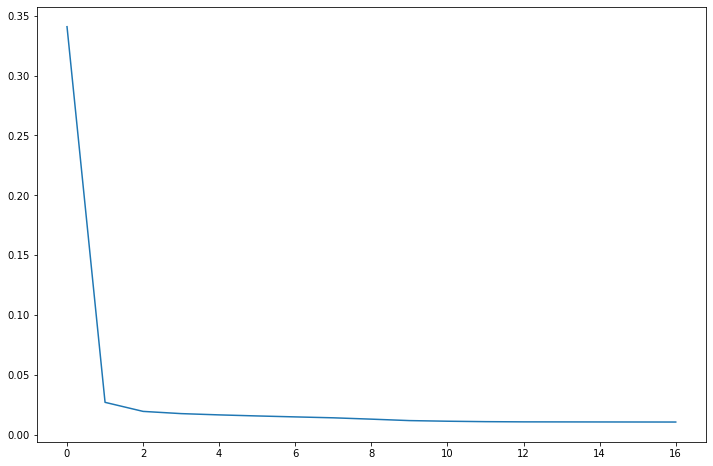

In [111]:
tf.print('OOF score is ',oof)

plt.figure(figsize=(12,8))

hist_trains = []
hist_lens = []
for i in range(n_folds*n_seeds):
    hist_train = (hists[i]).history['logloss']
    hist_trains.append(hist_train)
    hist_lens.append(len(hist_train))
hist_train = []
for i in range(min(hist_lens)):
    hist_train.append(np.mean([hist_trains[j][i] for j in range(n_folds*n_seeds)]))

plt.plot(hist_train)

hist_vals = []
hist_lens = []
for i in range(n_folds*n_seeds):
    hist_val = (hists[i]).history['val_logloss']
    hist_vals.append(hist_val)
    hist_lens.append(len(hist_val))
hist_val = []
for i in range(min(hist_lens)):
    hist_val.append(np.mean([hist_vals[j][i] for j in range(n_folds*n_seeds)]))

#plt.plot(hist_val)

#plt.yscale('log')
#plt.yticks(ticks=[1,1E-1,1E-2])
#plt.xlabel('Epochs')
#plt.ylabel('Average Logloss')
#plt.legend(['Training','Validation'])

In [112]:
sub = pd.read_csv('/kaggle/input/lish-moa/sample_submission.csv')
sub.iloc[:,1:] = np.clip(y_pred,p_min,p_max)

# Set ctl_vehicle to 0
sub.iloc[test_features['cp_type'] == 'ctl_vehicle',1:] = 0
sub5=sub.copy()
#sub6

# Blending

In [113]:
def order_sub(sub) : 
    return sub.sort_values('sig_id').reset_index(drop=True)

In [114]:
df1 = order_sub(sub1)
df2 = order_sub(sub2)
df3 = order_sub(sub3)
df4 = order_sub(sub4)
df5 = order_sub(sub5)
#df6 = order_sub(sub6)

df4 = order_sub(df4)
df5 = order_sub(df5)
df6 = order_sub(df6)
df7 = order_sub(df7)
df8 = order_sub(df8)
df9 = order_sub(df9)
df10 = order_sub(df10)

In [115]:
BLEND=df1.copy()
BLEND.iloc[:,1:] =  df1.iloc[:,1:]*0.4 +df2.iloc[:,1:]*0.20 +df3.iloc[:,1:]*0.15+df4.iloc[:,1:]*0.10+df5.iloc[:,1:]*0.15

In [116]:
#BLEND2=df1.copy()
#BLEND2.iloc[:,1:] =  df1.iloc[:,1:]*0.50 +df2.iloc[:,1:]*0.20 +df3.iloc[:,1:]*0.15+df4.iloc[:,1:]*0.15

In [117]:
TARGET_COL = ['5-alpha_reductase_inhibitor', '11-beta-hsd1_inhibitor', 'acat_inhibitor', 'acetylcholine_receptor_agonist', 'acetylcholine_receptor_antagonist', 'acetylcholinesterase_inhibitor', 'adenosine_receptor_agonist', 'adenosine_receptor_antagonist', 'adenylyl_cyclase_activator', 'adrenergic_receptor_agonist', 'adrenergic_receptor_antagonist', 'akt_inhibitor', 'aldehyde_dehydrogenase_inhibitor', 'alk_inhibitor', 'ampk_activator', 'analgesic', 'androgen_receptor_agonist', 'androgen_receptor_antagonist', 'anesthetic_-_local', 'angiogenesis_inhibitor', 'angiotensin_receptor_antagonist', 'anti-inflammatory', 'antiarrhythmic', 'antibiotic', 'anticonvulsant', 'antifungal', 'antihistamine', 'antimalarial', 'antioxidant', 'antiprotozoal', 'antiviral', 'apoptosis_stimulant', 'aromatase_inhibitor', 'atm_kinase_inhibitor', 'atp-sensitive_potassium_channel_antagonist', 'atp_synthase_inhibitor', 'atpase_inhibitor', 'atr_kinase_inhibitor', 'aurora_kinase_inhibitor', 'autotaxin_inhibitor', 'bacterial_30s_ribosomal_subunit_inhibitor', 'bacterial_50s_ribosomal_subunit_inhibitor', 'bacterial_antifolate', 'bacterial_cell_wall_synthesis_inhibitor', 'bacterial_dna_gyrase_inhibitor', 'bacterial_dna_inhibitor', 'bacterial_membrane_integrity_inhibitor', 'bcl_inhibitor', 'bcr-abl_inhibitor', 'benzodiazepine_receptor_agonist', 'beta_amyloid_inhibitor', 'bromodomain_inhibitor', 'btk_inhibitor', 'calcineurin_inhibitor', 'calcium_channel_blocker', 'cannabinoid_receptor_agonist', 'cannabinoid_receptor_antagonist', 'carbonic_anhydrase_inhibitor', 'casein_kinase_inhibitor', 'caspase_activator', 'catechol_o_methyltransferase_inhibitor', 'cc_chemokine_receptor_antagonist', 'cck_receptor_antagonist', 'cdk_inhibitor', 'chelating_agent', 'chk_inhibitor', 'chloride_channel_blocker', 'cholesterol_inhibitor', 'cholinergic_receptor_antagonist', 'coagulation_factor_inhibitor', 'corticosteroid_agonist', 'cyclooxygenase_inhibitor', 'cytochrome_p450_inhibitor', 'dihydrofolate_reductase_inhibitor', 'dipeptidyl_peptidase_inhibitor', 'diuretic', 'dna_alkylating_agent', 'dna_inhibitor', 'dopamine_receptor_agonist', 'dopamine_receptor_antagonist', 'egfr_inhibitor', 'elastase_inhibitor', 'erbb2_inhibitor', 'estrogen_receptor_agonist', 'estrogen_receptor_antagonist', 'faah_inhibitor', 'farnesyltransferase_inhibitor', 'fatty_acid_receptor_agonist', 'fgfr_inhibitor', 'flt3_inhibitor', 'focal_adhesion_kinase_inhibitor', 'free_radical_scavenger', 'fungal_squalene_epoxidase_inhibitor', 'gaba_receptor_agonist', 'gaba_receptor_antagonist', 'gamma_secretase_inhibitor', 'glucocorticoid_receptor_agonist', 'glutamate_inhibitor', 'glutamate_receptor_agonist', 'glutamate_receptor_antagonist', 'gonadotropin_receptor_agonist', 'gsk_inhibitor', 'hcv_inhibitor', 'hdac_inhibitor', 'histamine_receptor_agonist', 'histamine_receptor_antagonist', 'histone_lysine_demethylase_inhibitor', 'histone_lysine_methyltransferase_inhibitor', 'hiv_inhibitor', 'hmgcr_inhibitor', 'hsp_inhibitor', 'igf-1_inhibitor', 'ikk_inhibitor', 'imidazoline_receptor_agonist', 'immunosuppressant', 'insulin_secretagogue', 'insulin_sensitizer', 'integrin_inhibitor', 'jak_inhibitor', 'kit_inhibitor', 'laxative', 'leukotriene_inhibitor', 'leukotriene_receptor_antagonist', 'lipase_inhibitor', 'lipoxygenase_inhibitor', 'lxr_agonist', 'mdm_inhibitor', 'mek_inhibitor', 'membrane_integrity_inhibitor', 'mineralocorticoid_receptor_antagonist', 'monoacylglycerol_lipase_inhibitor', 'monoamine_oxidase_inhibitor', 'monopolar_spindle_1_kinase_inhibitor', 'mtor_inhibitor', 'mucolytic_agent', 'neuropeptide_receptor_antagonist', 'nfkb_inhibitor', 'nicotinic_receptor_agonist', 'nitric_oxide_donor', 'nitric_oxide_production_inhibitor', 'nitric_oxide_synthase_inhibitor', 'norepinephrine_reuptake_inhibitor', 'nrf2_activator', 'opioid_receptor_agonist', 'opioid_receptor_antagonist', 'orexin_receptor_antagonist', 'p38_mapk_inhibitor', 'p-glycoprotein_inhibitor', 'parp_inhibitor', 'pdgfr_inhibitor', 'pdk_inhibitor', 'phosphodiesterase_inhibitor', 'phospholipase_inhibitor', 'pi3k_inhibitor', 'pkc_inhibitor', 'potassium_channel_activator', 'potassium_channel_antagonist', 'ppar_receptor_agonist', 'ppar_receptor_antagonist', 'progesterone_receptor_agonist', 'progesterone_receptor_antagonist', 'prostaglandin_inhibitor', 'prostanoid_receptor_antagonist', 'proteasome_inhibitor', 'protein_kinase_inhibitor', 'protein_phosphatase_inhibitor', 'protein_synthesis_inhibitor', 'protein_tyrosine_kinase_inhibitor', 'radiopaque_medium', 'raf_inhibitor', 'ras_gtpase_inhibitor', 'retinoid_receptor_agonist', 'retinoid_receptor_antagonist', 'rho_associated_kinase_inhibitor', 'ribonucleoside_reductase_inhibitor', 'rna_polymerase_inhibitor', 'serotonin_receptor_agonist', 'serotonin_receptor_antagonist', 'serotonin_reuptake_inhibitor', 'sigma_receptor_agonist', 'sigma_receptor_antagonist', 'smoothened_receptor_antagonist', 'sodium_channel_inhibitor', 'sphingosine_receptor_agonist', 'src_inhibitor', 'steroid', 'syk_inhibitor', 'tachykinin_antagonist', 'tgf-beta_receptor_inhibitor', 'thrombin_inhibitor', 'thymidylate_synthase_inhibitor', 'tlr_agonist', 'tlr_antagonist', 'tnf_inhibitor', 'topoisomerase_inhibitor', 'transient_receptor_potential_channel_antagonist', 'tropomyosin_receptor_kinase_inhibitor', 'trpv_agonist', 'trpv_antagonist', 'tubulin_inhibitor', 'tyrosine_kinase_inhibitor', 'ubiquitin_specific_protease_inhibitor', 'vegfr_inhibitor', 'vitamin_b', 'vitamin_d_receptor_agonist', 'wnt_inhibitor']
NUM_TARGET = len(TARGET_COL)

In [118]:
#submission = pd.read_csv('/kaggle/input/lish-moa/sample_submission.csv')
df = pd.read_csv("/kaggle/input/lish-moa/sample_submission.csv")

public_id = list(df['sig_id'].values)

df_test = pd.read_csv('/kaggle/input/lish-moa/test_features.csv')
test_id = list(df_test['sig_id'].values)

private_id = list(set(test_id)-set(public_id))

df_submit1 = pd.DataFrame(index = public_id+private_id, columns=TARGET_COL)
df_submit1.index.name = 'sig_id'
df_submit1[:] = 0

df_predict1 = BLEND.copy()
df_submit1.loc[df_predict1.sig_id,:] = df_predict1[TARGET_COL].values
df_submit1.loc[df_test[df_test.cp_type=='ctl_vehicle'].sig_id]= 0
df_submit1.to_csv('submission.csv',index=True)



In [119]:
#df_submit1

In [120]:
#submission = pd.read_csv('/kaggle/input/lish-moa/sample_submission.csv')

In [121]:
#public_ids = list(submission['sig_id'].values)

#submission.shape

In [122]:
#test = pd.read_csv('/kaggle/input/lish-moa/test_features.csv')

#test_ids = list(test['sig_id'].values)

#private_ids = list(set(test_ids)-set(public_ids))

#len(private_ids)

In [123]:
#predictions = [sub3,sub2,sub1]

In [124]:
#sub1.to_csv('submission1.csv', index=False)
#sub2.to_csv('submission2.csv', index=False)
#sub3.to_csv('submission3.csv', index=False)
#sub4.to_csv('submission4.csv', index=False)

In [125]:
#predictions = [sub3,sub2,sub1]

In [126]:
#target_columns = list(submission.columns)
#target_columns.remove('sig_id')

In [127]:
#y_pred = pd.DataFrame()
#y_pred['sig_id'] = predictions[0]['sig_id']
'''
for column in target_columns:
    column_data = []
    for i in range(len(predictions)):
        column_data.append(predictions[i][column])
    y_pred[column] = np.mean(column_data, axis=0)
'''
#y_pred.shape

'\nfor column in target_columns:\n    column_data = []\n    for i in range(len(predictions)):\n        column_data.append(predictions[i][column])\n    y_pred[column] = np.mean(column_data, axis=0)\n'

In [128]:
#weights = [0.3345993850605896, 0.33387592693072893, 0.3315246880086815]

In [129]:
#weights = [0.70,0.15,0.15]
#weights2 = [0.5,0.3,0.2]

In [130]:
'''
weighted_y_pred = pd.DataFrame()
weighted_y_pred['sig_id'] = predictions[0]['sig_id']

for column in target_columns:
    column_data = []
    for i in range(len(predictions)):
        column_data.append(predictions[i][column] * weights[i])
    weighted_y_pred[column] = np.sum(column_data, axis=0)
'''
#weighted_y_pred.shape

"\nweighted_y_pred = pd.DataFrame()\nweighted_y_pred['sig_id'] = predictions[0]['sig_id']\n\nfor column in target_columns:\n    column_data = []\n    for i in range(len(predictions)):\n        column_data.append(predictions[i][column] * weights[i])\n    weighted_y_pred[column] = np.sum(column_data, axis=0)\n"

In [131]:
#y_pred = weighted_y_pred

In [132]:
'''
submission = pd.DataFrame(index = public_ids + private_ids, columns=target_columns)
submission.index.name = 'sig_id'

submission[:] = 0

submission.loc[y_pred.sig_id,:] = y_pred[target_columns].values

submission.loc[test[test.cp_type == 'ctl_vehicle'].sig_id] = 0

submission.to_csv('submission1.csv', index=True)
'''

"\nsubmission = pd.DataFrame(index = public_ids + private_ids, columns=target_columns)\nsubmission.index.name = 'sig_id'\n\nsubmission[:] = 0\n\nsubmission.loc[y_pred.sig_id,:] = y_pred[target_columns].values\n\nsubmission.loc[test[test.cp_type == 'ctl_vehicle'].sig_id] = 0\n\nsubmission.to_csv('submission1.csv', index=True)\n"

In [133]:
#submission

In [134]:
#weights2 = [0.60,0.15,0.25]

weighted_y_pred2 = pd.DataFrame()
weighted_y_pred2['sig_id'] = predictions[0]['sig_id']

for column in target_columns:
    column_data = []
    for i in range(len(predictions)):
        column_data.append(predictions[i][column] * weights2[i])
    weighted_y_pred2[column] = np.sum(column_data, axis=0)

#weighted_y_pred2.shape
y_pred2 = weighted_y_pred2

submission = pd.DataFrame(index = public_ids + private_ids, columns=target_columns)
submission.index.name = 'sig_id'

submission[:] = 0

submission.loc[y_pred2.sig_id,:] = y_pred2[target_columns].values

submission.loc[test[test.cp_type == 'ctl_vehicle'].sig_id] = 0

submission.to_csv('submission2.csv', index=True)

weights3 = [0.80,0.10,0.10]

weighted_y_pred3 = pd.DataFrame()
weighted_y_pred3['sig_id'] = predictions[0]['sig_id']

for column in target_columns:
    column_data = []
    for i in range(len(predictions)):
        column_data.append(predictions[i][column] * weights3[i])
    weighted_y_pred3[column] = np.sum(column_data, axis=0)

#weighted_y_pred2.shape
y_pred3 = weighted_y_pred3

submission = pd.DataFrame(index = public_ids + private_ids, columns=target_columns)
submission.index.name = 'sig_id'

submission[:] = 0

submission.loc[y_pred2.sig_id,:] = y_pred3[target_columns].values

submission.loc[test[test.cp_type == 'ctl_vehicle'].sig_id] = 0

submission.to_csv('submission3.csv', index=True)